# Imports

In [1]:
import nest
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import importlib
import constants
import random
importlib.reload(constants)
from constants import *
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.io as pio

import time
import warnings

nest.set_verbosity("M_ERROR") # SHUT UP NEST
nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
plt.ion()
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 150
pio.templates.default = "ggplot2"
warnings.filterwarnings("ignore")

## Introduction

Our main objective in this notebook is to simulate a hyperexcitable state in cortical networks,an effect that has been hypothesized to occur in autism due to the overpruning of long-range connections. In our model, we assume that long-range connections primarily provide inhibitory, modulatory control, whereas short-range connections are predominantly excitatory. This enforced connectivity scheme is intended to represent a “macro-scale” view within a relatively small network where each neuron approximates the activity of a larger cortical region.

By adopting this approach, we aim to demonstrate how the overpruning of long-range (inhibitory/modulatory) connections may lead to a loss of network integration, thereby impairing efficient communication between regions. It is important to note that although in biological cortical networks most long-range projections are excitatory, there is evidence that inhibitory modulation via long-range interactions can play a pivotal role in regulating neural dynamics, synchronizing oscillations, and maintaining overall network stability

## Helper functions for plotting connectivity

In [3]:
def get_positions(neurons) -> np.ndarray:
    """
    Get the positions of a list of neurons.
    (Assumes that nest.GetStatus(neurons, 'positions') returns a list of positions.)
    """
    return np.array(nest.GetPosition(neurons))

def get_positions_dict(layer_e, layer_i):
    """
    Returns dictionaries mapping neuron id -> position for excitatory and inhibitory populations.
    """
    positions_exc = {
        neuron: pos for neuron, pos in zip(layer_e, get_positions(layer_e))
    }
    positions_inh = {
        neuron: pos for neuron, pos in zip(layer_i, get_positions(layer_i))
    }
    return positions_exc, positions_inh

def spatial_distribution(layer_e, layer_i, fig=None, ax=None): 
    """
    Plot the spatial distribution of excitatory and inhibitory neurons

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    Returns:
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """

    positions_e = get_positions(layer_e)
    positions_i = get_positions(layer_i)

    if fig is None or ax is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        ax1, ax2 = ax
    ax1.scatter(positions_e[:, 0], positions_e[:, 1], c='#f8766d', label='Excitatory')
    ax1.scatter(positions_i[:, 0], positions_i[:, 1], c='#a3a500', label='Inhibitory')
    ax1.set_title("Spatial Distribution of Neurons")
    ax1.legend()

    
    fig.tight_layout()
    
    return fig, ax1, ax2

def find_positions(layer_e, layer_i):
    positions_exc = [(i + 1, pos) for i, pos in enumerate(layer_e.spatial["positions"])]
    start_index_inh = len(positions_exc) + 1 
    positions_inh = [(i + start_index_inh, pos) for i, pos in enumerate(layer_i.spatial["positions"])]
    # print(positions_exc)
    # print(positions_inh)
    
    positions_exc_dict = {neuron_id: pos for neuron_id, pos in positions_exc}
    positions_inh_dict = {neuron_id: pos for neuron_id, pos in positions_inh}

    return positions_exc_dict, positions_inh_dict

    
def find_plot_connections(connections, layer_e, layer_i, fig, ax1, ax2):
    """
    Visualize the connections between the neurons and plot the connectivity matrix

    Args:
        connections (list): List of connections
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """
    # source_node = int(input("Enter the source node: "))
    if isinstance(connections, list):
        all_connections = []
        for conn_collection in connections:
            all_connections.extend(list(conn_collection))  # Convert SynapseCollection to list of dictionaries
    else:
        all_connections = list(connections)  # Convert SynapseCollection to list of dictionaries
    
    source_node = 5
    center_neuron = nest.FindCenterElement(layer_e)
    cn_coords = center_neuron.spatial['positions']
   
    positions_exc, positions_inh = find_positions(layer_e, layer_i)

    source_pos = positions_exc.get(source_node) or positions_inh.get(source_node)
    if source_pos is None:
        print(f"Source node {source_node} not found in the network.")
    else:
        ax1.scatter(source_pos[0], source_pos[1], c='purple', label=f'Source Node {source_node}')

    for conn in all_connections:
        if conn.get("source") == source_node:
            target_node = conn.get("target")
            target_pos = positions_exc.get(target_node) or positions_inh.get(target_node)
            if target_pos is not None:
                ax1.plot([source_pos[0], target_pos[0]],
                         [source_pos[1], target_pos[1]],
                         c='black', alpha=0.2)

    fig.tight_layout()
    plot_connectivity_matrix(len(layer_e) + len(layer_i), all_connections, ax2)
    plt.show()

def plot_connectivity_matrix(total_neurons, connection_details, ax):
    """
    Plot the connectivity matrix of the network

    Args:
    """
    weight_matrix = np.zeros((total_neurons, total_neurons))
    for conn in connection_details:
        source = conn.get("source") - 1
        target = conn.get("target") - 1
        weight = conn.get("weight")
        weight_matrix[source, target] = weight

    sns.heatmap(weight_matrix, cmap='crest', ax=ax)

## Setup

In order to have synapses change through time such that we could apply pruning with respect to a threshold we decided to use the phenomenological model for short term plasticity for the connections in the excitatory neurons. Short-term synaptic plasticity contributes to the balance and regulation of brain networks from milliseconds to several minutes. The model comprises of 4 different state variables, but we mainly focus in the recovery variable $x(t)$ and the used resources variable $u(t)$

The model describes three state variables representing the synaptic resources:

- **Recovered or resting state**, with occupancy $x$
- **Active or conducting state**, $y$
- **Inactive state**, $z$

These satisfy the conservation equation:

$$
x + y + z = 1
$$

A fourth state variable, $u$, describes the "use" of synaptic resources in response to a presynaptic action potential arriving at $t = t_0$:

$$
\frac{du}{dt} = -\frac{u}{\tau_{\text{facil}}} + U(1 - u) \delta (t - t_0)
$$

where $u$ increases by $U(1 - u)$ with each action potential and decays back to zero with a time constant $\tau_{\text{facil}}$.

This $u$ drives the dynamics of the other three state variables:

$$
\frac{dx}{dt} = \frac{z}{\tau_{\text{rec}}} - u x \delta (t - t_0)
$$

$$
\frac{dy}{dt} = -\frac{y}{\tau_{\text{decay}}} + u x \delta (t - t_0)
$$

$$
\frac{dz}{dt} = \frac{y}{\tau_{\text{decay}}} - \frac{z}{\tau_{\text{rec}}}
$$

We decided to use a very small value of $U$ such that we have slow increments for $u(t)$, also to not have a strong facilitation effect we kept $\tau_{\text{facil}}$ << $\tau_{\text{rec}}$ thus having a fast enough reovery after each pre-synaptic spike

To stabilize excitatory neuron activity and achieve a balanced network, we implement an integrate-and-fire model with adaptive conductance. In this model, each spike increases the adaptive conductance, which temporarily reduces the neuron's excitability. This mechanism helps stabilize the firing rate when a constant stimulus is presented

*Note* : All values of the parameters can be found in the `constans.py` file


In [4]:
def create_populations():
    """
    Create populations of excitatory and inhibitory neurons with spatial distribution

    Returns:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    E_neuron_params = {
        "E_L": E_NEURON_E_L,
        "C_m": E_NEURON_C_M,
        "t_ref": E_NEURON_T_REF,
        "V_th": E_NEURON_V_TH,
        "V_reset": E_NEURON_V_RESET,
        "tau_syn_ex": E_NEURON_TAU_SYN_EX,
        "tau_syn_in": E_NEURON_TAU_SYN_IN,
        "a": ADAPTATION_a,         
        "b": ADAPTATION_b,         
        "tau_w": ADAPTATION_tau_w  
    }

    I_neuron_params = {
        "E_L": I_NEURON_E_L,
        "C_m": I_NEURON_C_M,
        "tau_m": I_NEURON_TAU_M,
        "t_ref": I_NEURON_T_REF,
        "V_th": I_NEURON_V_TH,
        "V_reset": I_NEURON_V_RESET,
        "tau_syn_ex": I_NEURON_TAU_SYN_EX,
        "tau_syn_in": I_NEURON_TAU_SYN_IN,
        "I_e": INH_BACKGROUND
    }

    pop_size_E = POP_SIZE_E
    pop_size_I = POP_SIZE_I


    nest.CopyModel("aeif_cond_alpha", "exc_iaf_psc_alpha")
    nest.SetDefaults("exc_iaf_psc_alpha", E_neuron_params)

    nest.CopyModel("iaf_psc_alpha", "inh_iaf_psc_alpha")
    nest.SetDefaults("inh_iaf_psc_alpha", I_neuron_params)

    # random distribution of neurons in the 2d space
    pos_e = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )
    pos_i = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )

    # creating the two populations
    layer_e = nest.Create("exc_iaf_psc_alpha", n=pop_size_E, positions=pos_e)
    layer_i = nest.Create("inh_iaf_psc_alpha", n=pop_size_I, positions=pos_i)
    
    return layer_e, layer_i

def connect_pop_base(layer_e, layer_i, plot_connections=True):
    """
    Connect the populations with specific spatial synaptic rules

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """

    # Distance‐dependent connection rule for short range connectivity
    distribution_exc = nest.spatial_distributions.gaussian(nest.spatial.distance, std=EXC_GAUSSIAN_STD)
    conndict_exc = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution_exc > EXC_DISTRIBUTION_THRESHOLD, distribution_exc, 0),
        "mask": {"circular": {"radius": EXC_MASK_RADIUS}},
    }

    # Distance‐dependent connection rule for long range connectivity
    distribution_inh = nest.spatial_distributions.gaussian(nest.spatial.distance, std=INH_GAUSSIAN_STD)
    conndict_inh = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution_inh > INH_DISTRIBUTION_THRESHOLD, distribution_inh, 0),
        "mask": {"circular": {"radius": INH_MASK_RADIUS}},
    }

    # Define synapse parameters
    syn_params = {
        "U": 0.04,
        "u": 0.0,
        "tau_rec": 500.0,
        "tau_fac": 400.0,
        "weight" : EXC_WEIGHT
    }
    nest.CopyModel("tsodyks_synapse", "synapse", syn_params)

    # Define inhibitory synapse parameters
    static_inh_params = {
        "weight": INH_WEIGHT,  
        "delay": DELAY_CONNECTION 
    }
    nest.CopyModel("static_synapse", "inhibitory_synapse", static_inh_params)

    # Excitatory to excitatory: local (short-range)
    nest.Connect(layer_e, layer_e, conndict_exc, syn_spec={"synapse_model": "synapse"})
    # Excitatory to inhibitory: local (short-range)
    nest.Connect(layer_e, layer_i, conndict_exc, syn_spec={"synapse_model": "synapse"})
    
    # Inhibitory to excitatory: long-range
    nest.Connect(layer_i, layer_e, conndict_inh, syn_spec={"synapse_model": "inhibitory_synapse"})
    # Inhibitory to inhibitory: long-range
    nest.Connect(layer_i, layer_i, conndict_inh, syn_spec={"synapse_model": "inhibitory_synapse"})

    connections_exc = nest.GetConnections(synapse_model="synapse")
    connections_inh = nest.GetConnections(synapse_model="inhibitory_synapse")

    all_connections = [connections_exc, connections_inh]
    if plot_connections:
        # Useful for plotting
        figT, ax1, ax2 = spatial_distribution(layer_e, layer_i)
        find_plot_connections(all_connections, layer_e, layer_i, figT, ax1, ax2)
        print("Number of excitatory connections: ", len(connections_exc))
        print("Number of inhibitory connections: ", len(connections_inh))
    else:
        return all_connections

def create_thalamic_input(layer_e, firing_rate=THALAMIC_INPUT_FIRING_RATE, weight=THALAMIC_INPUT_WEIGHT, delay=THALAMIC_INPUT_DELAY):
    """
    Create a Poisson generator to simulate thalamic input to the excitatory neurons
    """
    thalamic_input = nest.Create("poisson_generator", params={"rate": firing_rate})
    nest.Connect(thalamic_input, layer_e, syn_spec={"weight": weight, "delay": delay}) 
    return thalamic_input

def create_dc_input(layer_e, start = DC_INPUT_START_1, stop=DC_INPUT_STOP_1):
    """
    Create a DC generator to simulate a constant input to the excitatory neurons
    """
    dc_input = nest.Create("dc_generator")
    
    nest.SetStatus(dc_input, {
        "amplitude": DC_INPUT_AMPLITUDE,  # pA 
        "start": start,   
        "stop": stop    
        })
    
    nest.Connect(dc_input, layer_e, syn_spec={"weight": DC_INPUT_WEIGHT, "delay": DC_INPUT_DELAY})

    return dc_input

## Monitoring

In [7]:
def recording_devices(layer_e, layer_i, input = None, ind_neuron=False):
    """
    Connect recording devices
    """
    sr_e = nest.Create("spike_recorder")
    sr_i = nest.Create("spike_recorder")
    nest.Connect(layer_e, sr_e)
    nest.Connect(layer_i, sr_i)

    if input:
        sr_input = nest.Create("spike_recorder")
        nest.Connect(input, sr_input)

    if ind_neuron:
        multimeter_e = nest.Create("multimeter", params={
        "record_from": ["V_m", "w"],
        "interval": 0.1})
        nest.Connect(multimeter_e, layer_e[0])
    else:
        multimeter_e = nest.Create("multimeter", params={"record_from": ["V_m", "g_ex"], "interval": 0.1})
    
    multimeter_i = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    nest.Connect(multimeter_e, layer_e)
    nest.Connect(multimeter_i, layer_i)

    sr_input = None
    
    return multimeter_e, multimeter_i, sr_e, sr_i, sr_input

def plot_spikes(sr_e, sr_i, sr_input = None):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    spike_events_i = nest.GetStatus(sr_i, "events")[0]
    
    senders_e = spike_events_e["senders"]
    times_e = spike_events_e["times"]
    senders_i = spike_events_i["senders"]
    times_i = spike_events_i["times"]

    if sr_input:
        # poisson generator
        spike_events_input = nest.GetStatus(sr_input, "events")[0]
        # print(spike_events_input)
        senders_input = spike_events_input["senders"]
        times_input = spike_events_input["times"]

    dots_size = 3

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(times_e, senders_e, s=dots_size, label="Excitatory", color="#f8766d")
    ax.scatter(times_i, senders_i, s=dots_size, label="Inhibitory", color="#a3a500")
    if sr_input:
        ax.scatter(times_input, senders_input, s=dots_size, label="Input", color="orange")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_voltages(multimeter_e, multimeter_i):
    multimeter_events_e = nest.GetStatus(multimeter_e, "events")[0]
    multimeter_events_i = nest.GetStatus(multimeter_i, "events")[0]

    w = multimeter_events_e["w"]   
    senders_e = multimeter_events_e["senders"]  

    times_e = multimeter_events_e["times"]
    voltages_e = multimeter_events_e["V_m"]
    times_i = multimeter_events_i["times"]
    voltages_i = multimeter_events_i["V_m"]


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 5))
    ax1.plot(times_e, voltages_e, label="Excitatory", color="red")
    ax1.plot(times_i, voltages_i, label="Inhibitory", color="blue")
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Membrane potential (mV)")
    ax1.legend()
    ax2.plot(times_e, w, label=f"Neuron {senders_e[0]}", color="green")
    plt.tight_layout()
    plt.show()


In [8]:
def compute_firing_rate_stats(spike_detector, t_sim):
    """
    Compute mean and variance of firing rates across neurons, as well as
    individual firing rates for further analysis.
    
    Args:
        spike_detector: The NEST spike detector that recorded from a population
        t_sim (float): Simulation time in ms
        n_neurons (int): (Optional) total number of neurons in the population 
                         that were connected to this detector. If None, we infer 
                         from 'senders'.
    Returns:
        mean_fr (float): Mean firing rate (Hz) across all neurons
        var_fr (float): Variance of firing rates
        frs (list of float): Individual firing rates for each neuron (Hz)
    """
    events = nest.GetStatus(spike_detector, "events")[0]
    senders = events["senders"]
    times = events["times"]
    unique_senders = np.unique(senders)


    frs = []
    sim_time_s = t_sim / 1000.0 

    for neuron_id in unique_senders:
        neuron_spike_times = times[senders == neuron_id]
        # Firing rate = #spikes / simulation time
        fr = len(neuron_spike_times) / sim_time_s
        frs.append(fr)

    mean_fr = np.mean(frs)
    var_fr = np.var(frs)
    return mean_fr, var_fr, frs

def compute_cv_isi(spike_detector):
    """
    Compute the average CV of the inter-spike intervals (ISIs) across all neurons 
    recorded by the given spike detector.
    
    Returns:
        mean_cv (float): Mean CV of all neurons that fired >= 2 spikes
        cv_list (list): CV for each neuron (NaN for neurons with <2 spikes)
    """
    events = nest.GetStatus(spike_detector, "events")[0]
    senders = events["senders"]
    times = events["times"]

    unique_senders = np.unique(senders)
    cv_list = []

    for neuron_id in unique_senders:
        neuron_spike_times = times[senders == neuron_id]
        if len(neuron_spike_times) < 2:
            cv_list.append(np.nan)
            continue
        isi = np.diff(neuron_spike_times)
        cv = np.std(isi) / np.mean(isi)
        cv_list.append(cv)

    mean_cv = np.nanmean(cv_list)
    return mean_cv, cv_list

In [9]:
def print_stats(sr_e, sr_i):
    mean_fr_e, var_fr_e, frs_e = compute_firing_rate_stats(sr_e, t_sim=SIM_TIME)
    mean_fr_i, var_fr_i, frs_i = compute_firing_rate_stats(sr_i, t_sim=SIM_TIME)
    mean_cv_e, cv_list_e = compute_cv_isi(sr_e)
    mean_cv_i, cv_list_i = compute_cv_isi(sr_i)

    print("Excitatory population:")
    print(f"  Mean firing rate: {mean_fr_e:.2f} Hz")
    print(f"  Variance of firing rate: {var_fr_e:.2f}")
    print(f"  Mean CV of ISIs: {mean_cv_e:.2f}")

    print("Inhibitory population:")
    print(f"  Mean firing rate: {mean_fr_i:.2f} Hz")
    print(f"  Variance of firing rate: {var_fr_i:.2f}")
    print(f"  Mean CV of ISIs: {mean_cv_i:.2f}")

# Network Setup

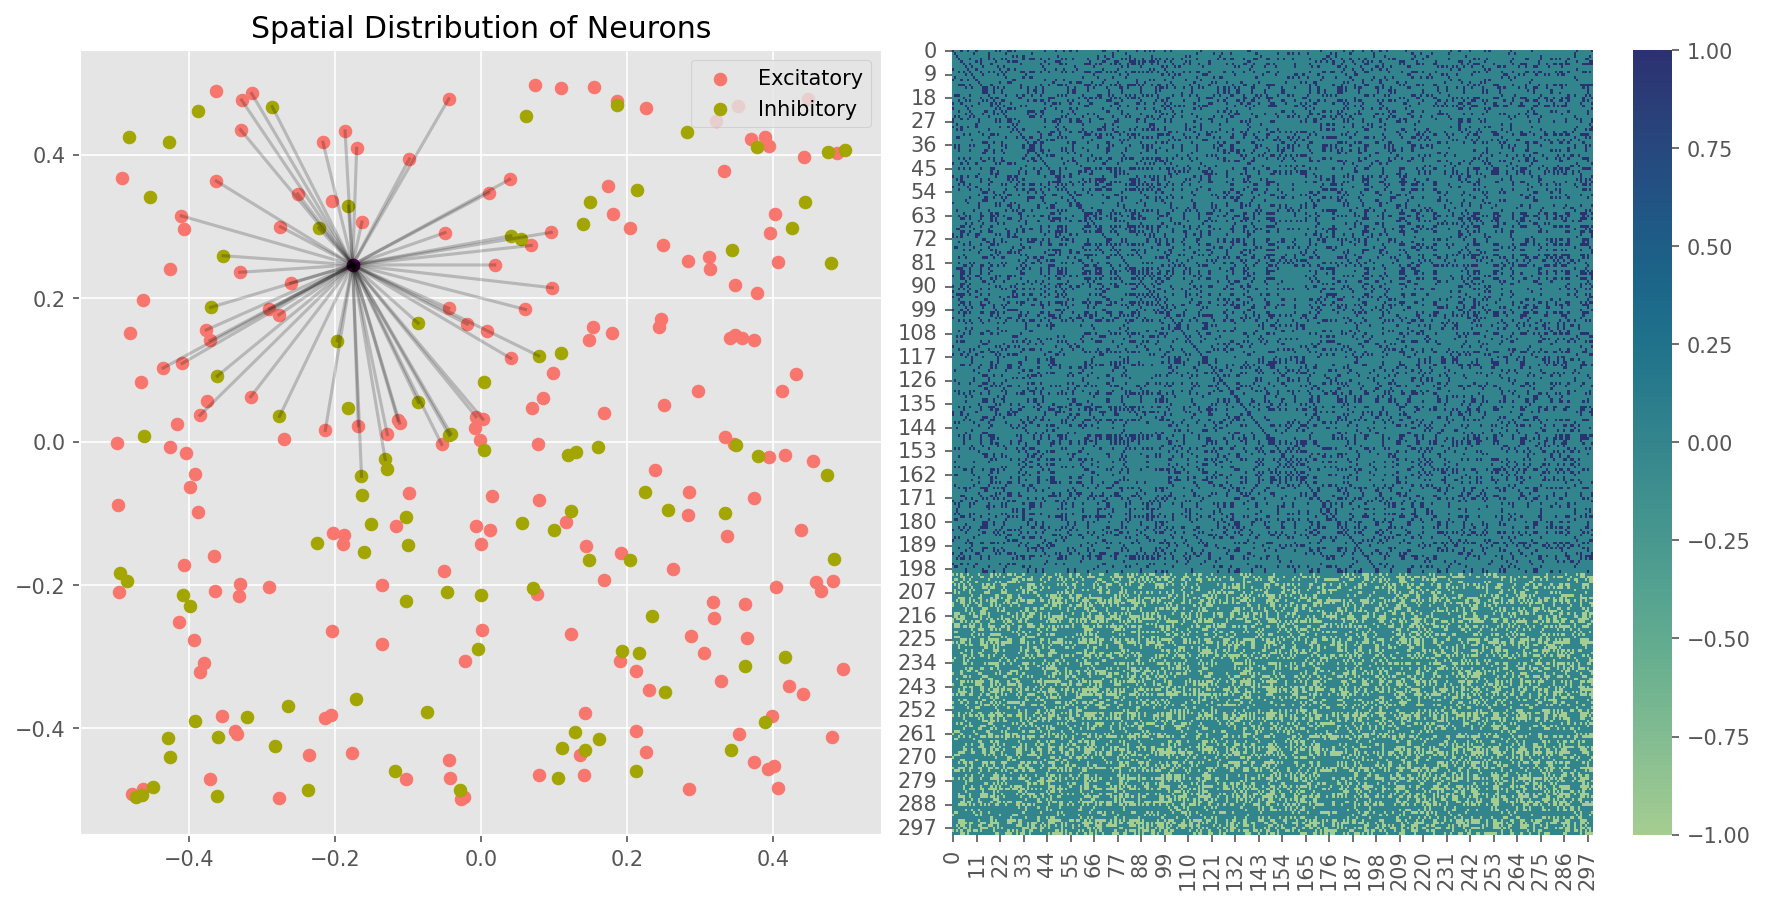

Number of excitatory connections:  11153
Number of inhibitory connections:  9462


In [77]:
nest.ResetKernel() 
layer_e, layer_i = create_populations()
connect_pop_base(layer_e, layer_i)
# _ = create_dc_input(layer_e, start=DC_INPUT_START_1, stop=DC_INPUT_STOP_1)
#_ = create_dc_input(layer_e, start=DC_INPUT_START_2, stop=DC_INPUT_STOP_2)
# input = None
input = create_thalamic_input(layer_e)
mr_e, mr_i, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input) 

# Monitoring Synapses Evolution

The following code:

1. splits the connections in exc-exc, exc-inh, inh-exc, inh-inh
2. simulate for each step for an amount of time defined by step_duration, for each steps it retrieves u and x values for each type of connection
3. plots with two scatter plots the progression of each type

Because we are using the Tsodyks model for excitatory synapses, we find it useful to monitor the evolution of its parameters, u and x, over the simulation time. By plotting the time course of u and x, we can verify that the short-term plasticity dynamics are behaving as expected. This monitoring not only provides insight into the underlying synaptic modulation but also helps ensure that the network dynamics remain stable and well-regulated during simulation

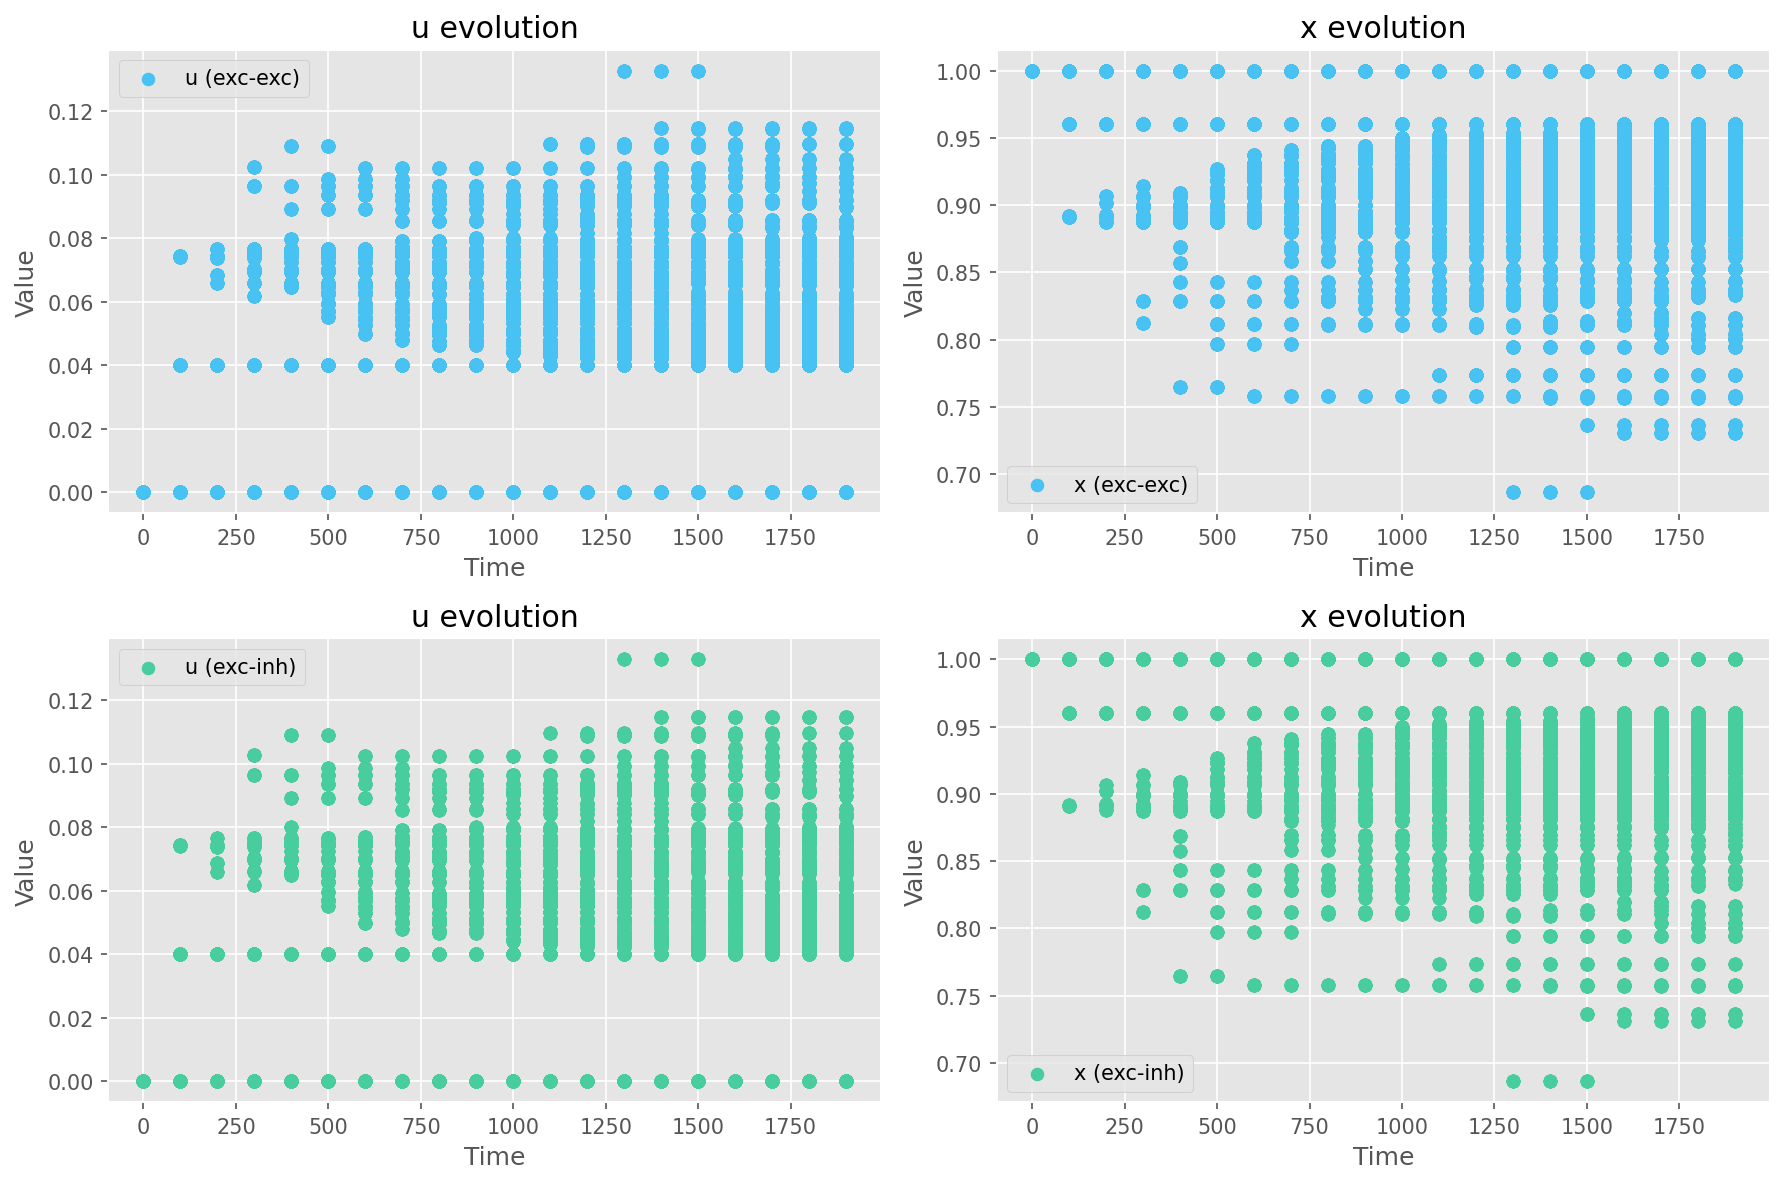

In [78]:
# GET SOME CONNECTIONS TO PLOT
exc_exc = nest.GetConnections(source=layer_e, target=layer_e, synapse_model="synapse")
exc_inh = nest.GetConnections(source=layer_e, target=layer_i, synapse_model="synapse")
inh_exc = nest.GetConnections(source=layer_i, target=layer_e, synapse_model="synapse")
inh_inh = nest.GetConnections(source=layer_i, target=layer_i, synapse_model="synapse")

steps = STEPS
step_duration = STEPS_DURATION
time = 0

# initialization
u_values_exc_exc, u_values_exc_inh, u_values_inh_exc, u_values_inh_inh = [], [], [], []
x_values_exc_exc, x_values_exc_inh, x_values_inh_exc, x_values_inh_inh = [], [], [], []

timesteps = [step_duration*step for step in range(steps)]


for i in range(steps):
    # Retrieve u and x Values
    u_values_exc_exc.append(nest.GetStatus(exc_exc, "u"))
    u_values_exc_inh.append(nest.GetStatus(exc_inh, "u"))
    u_values_inh_exc.append(nest.GetStatus(inh_exc, "u"))
    u_values_inh_inh.append(nest.GetStatus(inh_inh, "u"))

    x_values_exc_exc.append(nest.GetStatus(exc_exc, "x"))
    x_values_exc_inh.append(nest.GetStatus(exc_inh, "x"))
    x_values_inh_exc.append(nest.GetStatus(inh_exc, "x"))
    x_values_inh_inh.append(nest.GetStatus(inh_inh, "x"))
    time += step_duration
    nest.Simulate(step_duration)

u_exc_exc_flattened = np.concatenate(u_values_exc_exc)
u_exc_inh_flattened = np.concatenate(u_values_exc_inh)
u_inh_exc_flattened = np.concatenate(u_values_inh_exc)
u_inh_inh_flattened = np.concatenate(u_values_inh_inh)
x_exc_exc_flattened = np.concatenate(x_values_exc_exc)
x_exc_inh_flattened = np.concatenate(x_values_exc_inh)
x_inh_exc_flattened = np.concatenate(x_values_inh_exc)
x_inh_inh_flattened = np.concatenate(x_values_inh_inh)

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

axes[0,0].scatter(np.repeat(timesteps, len(u_values_exc_exc[0])), u_exc_exc_flattened, color="#47c2f3", label="u (exc-exc)")
axes[1,0].scatter(np.repeat(timesteps, len(u_values_exc_inh[0])), u_exc_inh_flattened, color="#47cd9e", label="u (exc-inh)")
# axes[0].scatter(np.repeat(timesteps, len(u_values_inh_exc[0])), u_inh_exc_flattened, color="green", label="u (inh-exc)", alpha=0.8)
# axes[0].scatter(np.repeat(timesteps, len(u_values_inh_inh[0])), u_inh_inh_flattened, color="purple", label="u (inh-inh)", alpha=0.1)
axes[0,1].scatter(np.repeat(timesteps, len(x_values_exc_exc[0])), x_exc_exc_flattened, color="#47c2f3", label="x (exc-exc)")
axes[1,1].scatter(np.repeat(timesteps, len(x_values_exc_inh[0])), x_exc_inh_flattened, color="#47cd9e", label="x (exc-inh)")
# axes[1].scatter(np.repeat(timesteps, len(x_values_inh_exc[0])), x_inh_exc_flattened, color="green", label="x (inh-exc)", alpha=0.7)
# axes[1].scatter(np.repeat(timesteps, len(x_values_inh_inh[0])), x_inh_inh_flattened, color="purple", label="x (inh-inh)", alpha=0.7)

axes[0,0].set_xlabel("Time")
axes[0,0].set_ylabel("Value")
axes[0,0].set_title("u evolution")
axes[1,0].set_xlabel("Time")
axes[1,0].set_ylabel("Value")
axes[1,0].set_title("u evolution")
axes[1,1].set_xlabel("Time")
axes[1,1].set_ylabel("Value")
axes[1,1].set_title("x evolution")
axes[0,1].set_xlabel("Time")
axes[0,1].set_ylabel("Value")
axes[0,1].set_title("x evolution")
axes[0,0].legend()
axes[1,0].legend()
axes[0,1].legend()
axes[1,1].legend()
plt.tight_layout()
plt.show()

In these plots we show the evolution of the state variables $u$ and $x$ during the simulation for the 2 defined plastic synapses seeing oscillating dynamic for the two thus a good trade-off or balance between the resource usage and the recovery of the vescicles. 

## Mean + STD

In the following i take the above measure and plot a summary of the values with mean and std

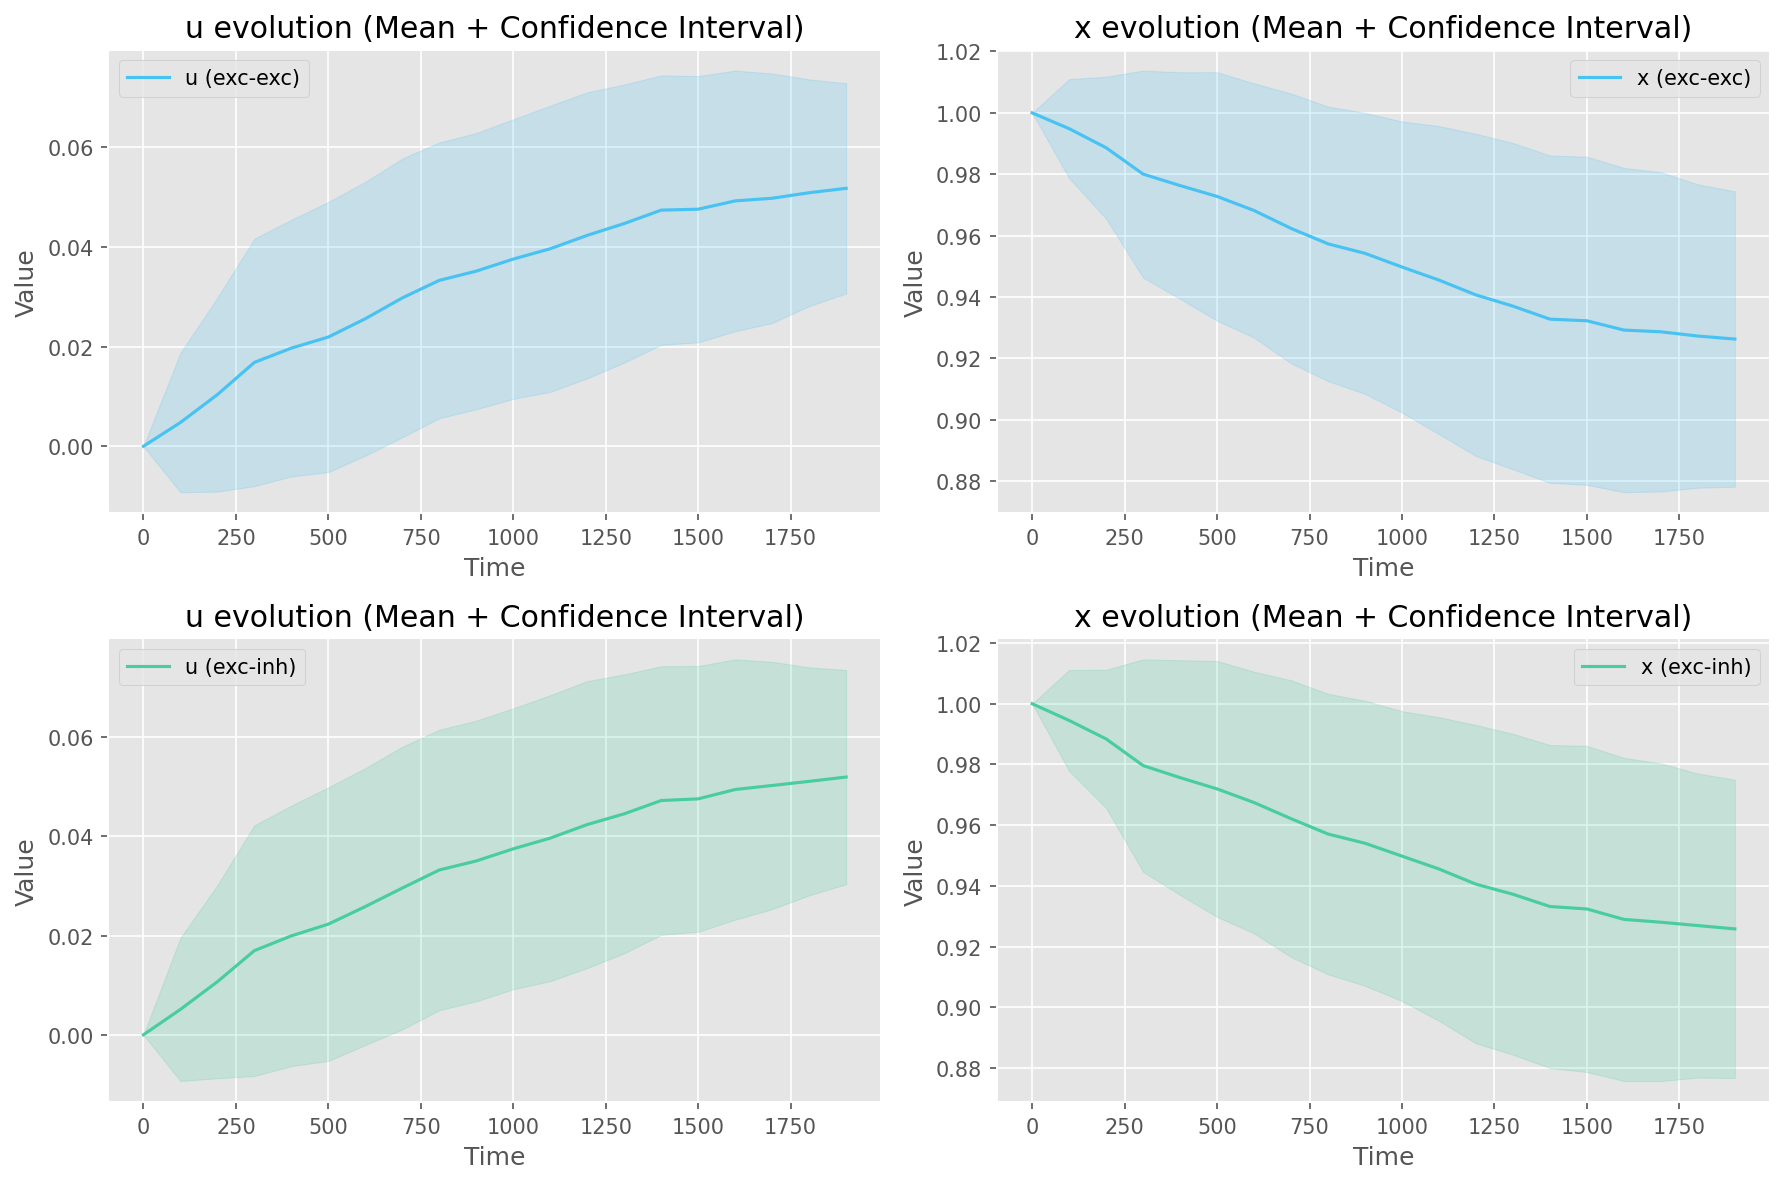

In [79]:
# Compute mean and standard deviation for confidence intervals
def compute_stats(values_list):
    means = [np.mean(values) for values in values_list]
    stds = [np.std(values) for values in values_list]
    return np.array(means), np.array(stds)

# Compute stats for u values
u_exc_exc_mean, u_exc_exc_std = compute_stats(u_values_exc_exc)
u_exc_inh_mean, u_exc_inh_std = compute_stats(u_values_exc_inh)
u_inh_exc_mean, u_inh_exc_std = compute_stats(u_values_inh_exc)
u_inh_inh_mean, u_inh_inh_std = compute_stats(u_values_inh_inh)

# Compute stats for x values
x_exc_exc_mean, x_exc_exc_std = compute_stats(x_values_exc_exc)
x_exc_inh_mean, x_exc_inh_std = compute_stats(x_values_exc_inh)
x_inh_exc_mean, x_inh_exc_std = compute_stats(x_values_inh_exc)
x_inh_inh_mean, x_inh_inh_std = compute_stats(x_values_inh_inh)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Line plot for u values with confidence interval
axes[0,0].plot(timesteps, u_exc_exc_mean, color="#47c2f3", label="u (exc-exc)")
axes[0,0].fill_between(timesteps, u_exc_exc_mean - u_exc_exc_std, u_exc_exc_mean + u_exc_exc_std, color="#47c2f3", alpha=0.2)
axes[1,0].plot(timesteps, u_exc_inh_mean, color="#47cd9e", label="u (exc-inh)")
axes[1,0].fill_between(timesteps, u_exc_inh_mean - u_exc_inh_std, u_exc_inh_mean + u_exc_inh_std, color="#47cd9e", alpha=0.2)
# axes[0].plot(timesteps, u_inh_exc_mean, color="green", label="u (inh-exc)")
# axes[0].fill_between(timesteps, u_inh_exc_mean - u_inh_exc_std, u_inh_exc_mean + u_inh_exc_std, color="green", alpha=0.2)
# axes[0].plot(timesteps, u_inh_inh_mean, color="purple", label="u (inh-inh)")
# axes[0].fill_between(timesteps, u_inh_inh_mean - u_inh_inh_std, u_inh_inh_mean + u_inh_inh_std, color="purple", alpha=0.2)
axes[0,0].set_title("u evolution (Mean + Confidence Interval)")
axes[0,0].set_xlabel("Time")
axes[0,0].set_ylabel("Value")
axes[0,0].legend()
axes[1,0].set_title("u evolution (Mean + Confidence Interval)")
axes[1,0].set_xlabel("Time")
axes[1,0].set_ylabel("Value")
axes[1,0].legend()

# Line plot for x values with confidence interval
axes[0,1].plot(timesteps, x_exc_exc_mean, color="#47c2f3", label="x (exc-exc)")
axes[0,1].fill_between(timesteps, x_exc_exc_mean - x_exc_exc_std, x_exc_exc_mean + x_exc_exc_std, color="#47c2f3", alpha=0.2)
axes[1,1].plot(timesteps, x_exc_inh_mean, color="#47cd9e", label="x (exc-inh)")
axes[1,1].fill_between(timesteps, x_exc_inh_mean - x_exc_inh_std, x_exc_inh_mean + x_exc_inh_std, color="#47cd9e", alpha=0.2)
# axes[1].plot(timesteps, x_inh_exc_mean, color="green", label="x (inh-exc)")
# axes[1].fill_between(timesteps, x_inh_exc_mean - x_inh_exc_std, x_inh_exc_mean + x_inh_exc_std, color="green", alpha=0.2)
# axes[1].plot(timesteps, x_inh_inh_mean, color="purple", label="x (inh-inh)")
# axes[1].fill_between(timesteps, x_inh_inh_mean - x_inh_inh_std, x_inh_inh_mean + x_inh_inh_std, color="purple", alpha=0.2)
axes[0,1].set_title("x evolution (Mean + Confidence Interval)")
axes[0,1].set_xlabel("Time")
axes[0,1].set_ylabel("Value")
axes[0,1].legend()
axes[1,1].set_title("x evolution (Mean + Confidence Interval)")
axes[1,1].set_xlabel("Time")
axes[1,1].set_ylabel("Value")
axes[1,1].legend()

plt.tight_layout()
plt.show()

These plots show the mean and overall varation of the two states variables, here we can clearly see a monotonistic increase / decrease respectevely for the two implying a more or less stable dynamics, expected as we provide the network with a background activity the entire time

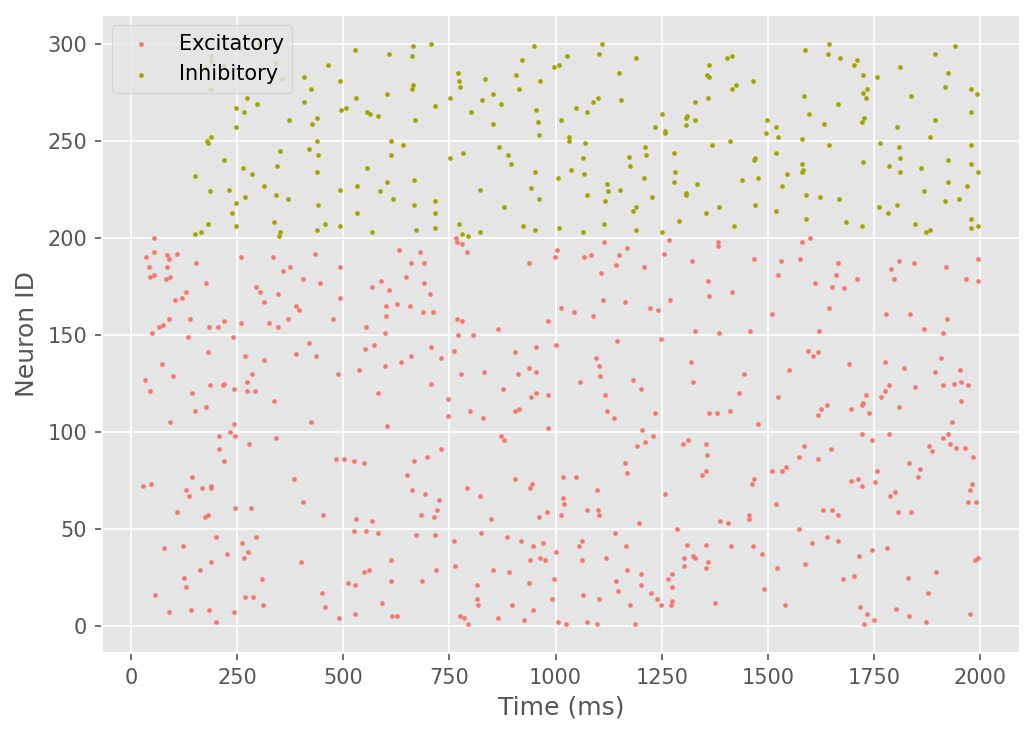

In [80]:
plot_spikes(sr_e, sr_i, sr_input)

Here we plot the spikes of the network over the entire simulation, again showcasing sustained activity due to the mirrowing of the input

In [81]:
print_stats(sr_e, sr_i)

Excitatory population:
  Mean firing rate: 1.30 Hz
  Variance of firing rate: 0.46
  Mean CV of ISIs: 0.36
Inhibitory population:
  Mean firing rate: 1.48 Hz
  Variance of firing rate: 0.55
  Mean CV of ISIs: 0.25


By showing these statistics, we can quantify the network's activity to assess its stability and balance. The mean firing rates for both populations are relatively low (1.30 Hz for excitatory and 1.48 Hz for inhibitory), suggesting that the network is not overly active, which is desirable for maintaining stability and preventing runaway excitation

The variance of firing rates is also low, indicating that individual neurons do not deviate significantly from the mean. However, the coefficient of variation (CV) of interspike intervals is lower than what is typically expected in a fully balanced network (0.36 for excitatory and 0.25 for inhibitory). In balanced activity, we usually expect more irregular, asynchronous firing, often with CV values closer to or above 1. The observed lower CV suggests that neurons are firing in a more regular pattern than expected

This could be due to several factors, including the intrinsic properties of the neuron models used or the nature of the input driving the network

# Finding The Minimum Stimulus For Our Network to be Hyper-Excitable

## When is our network hyper-excitable?

To define a state of 'hyper-excitability', we first need to quantify the network's excitability. To achieve this, we will run multiple simulations while systematically increasing the thalamic input. By plotting the average firing rate of the neurons as a function of the thalamic input, we can determine how the network's excitability changes and identify the threshold at which hyper-excitability occurs

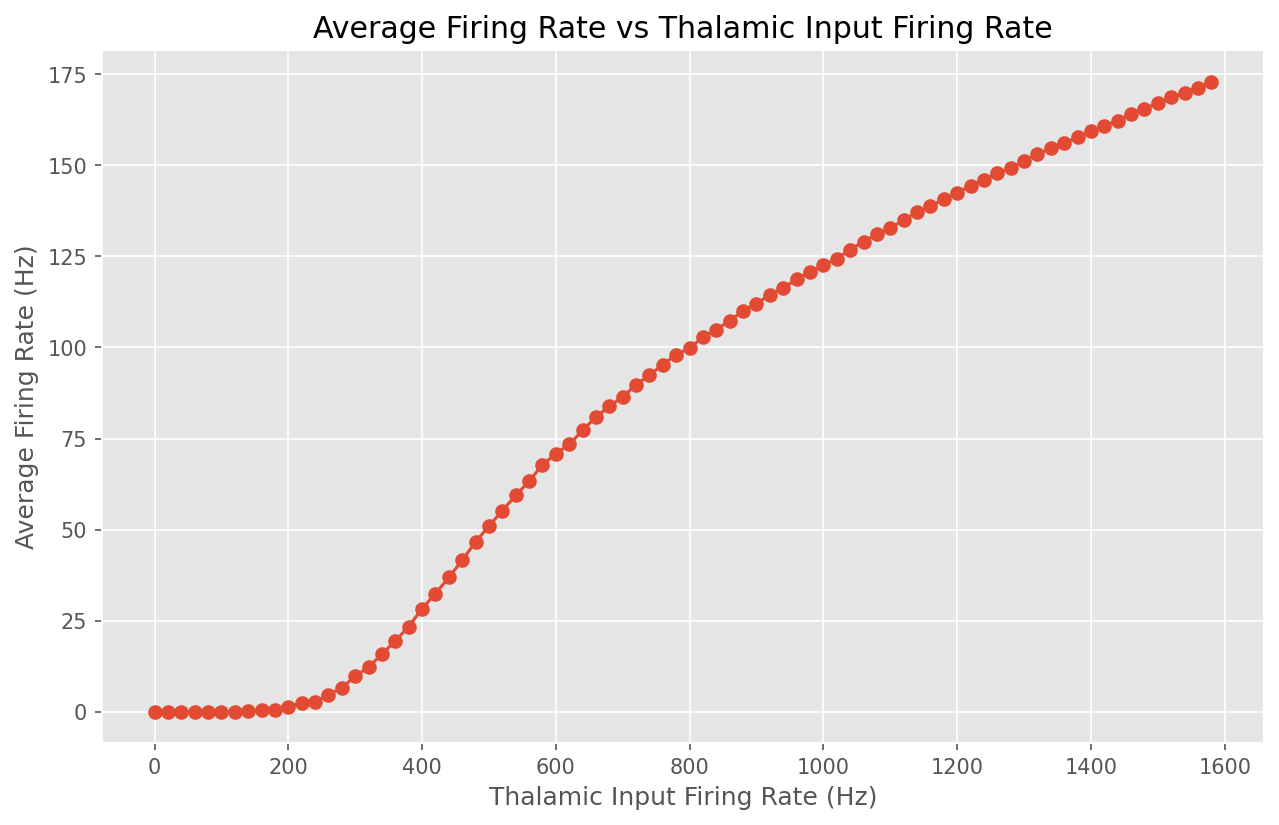

In [13]:
thalamic_firing_rates = [20 * i for i in range(80)]
firing_rates = []
sim_time = 150.0

for firing_rate in thalamic_firing_rates:
    nest.ResetKernel()
    layer_e, layer_i = create_populations()
    connect_pop_base(layer_e, layer_i, plot_connections=False)
    input = create_thalamic_input(layer_e, firing_rate=firing_rate)
    _, _, sr_e, sr_i, _ = recording_devices(layer_e, layer_i, input)
    nest.Simulate(sim_time)
    spike_data = nest.GetStatus(sr_e, "events")[0]

    spike_times = spike_data["times"]
    senders = spike_data["senders"]

    # Compute firing rate (spikes per second per neuron)
    num_spikes = len(spike_times)
    num_neurons = len(layer_e)
    firing_rate = num_spikes / (num_neurons * (sim_time / 1000))  # Hz
    firing_rates.append(firing_rate)

plt.figure(figsize=(10, 6))
plt.plot(thalamic_firing_rates, firing_rates, marker='o')
plt.xlabel('Thalamic Input Firing Rate (Hz)')
plt.ylabel('Average Firing Rate (Hz)')
plt.title('Average Firing Rate vs Thalamic Input Firing Rate')
plt.grid(True)
plt.show()


## Let's visualize the above

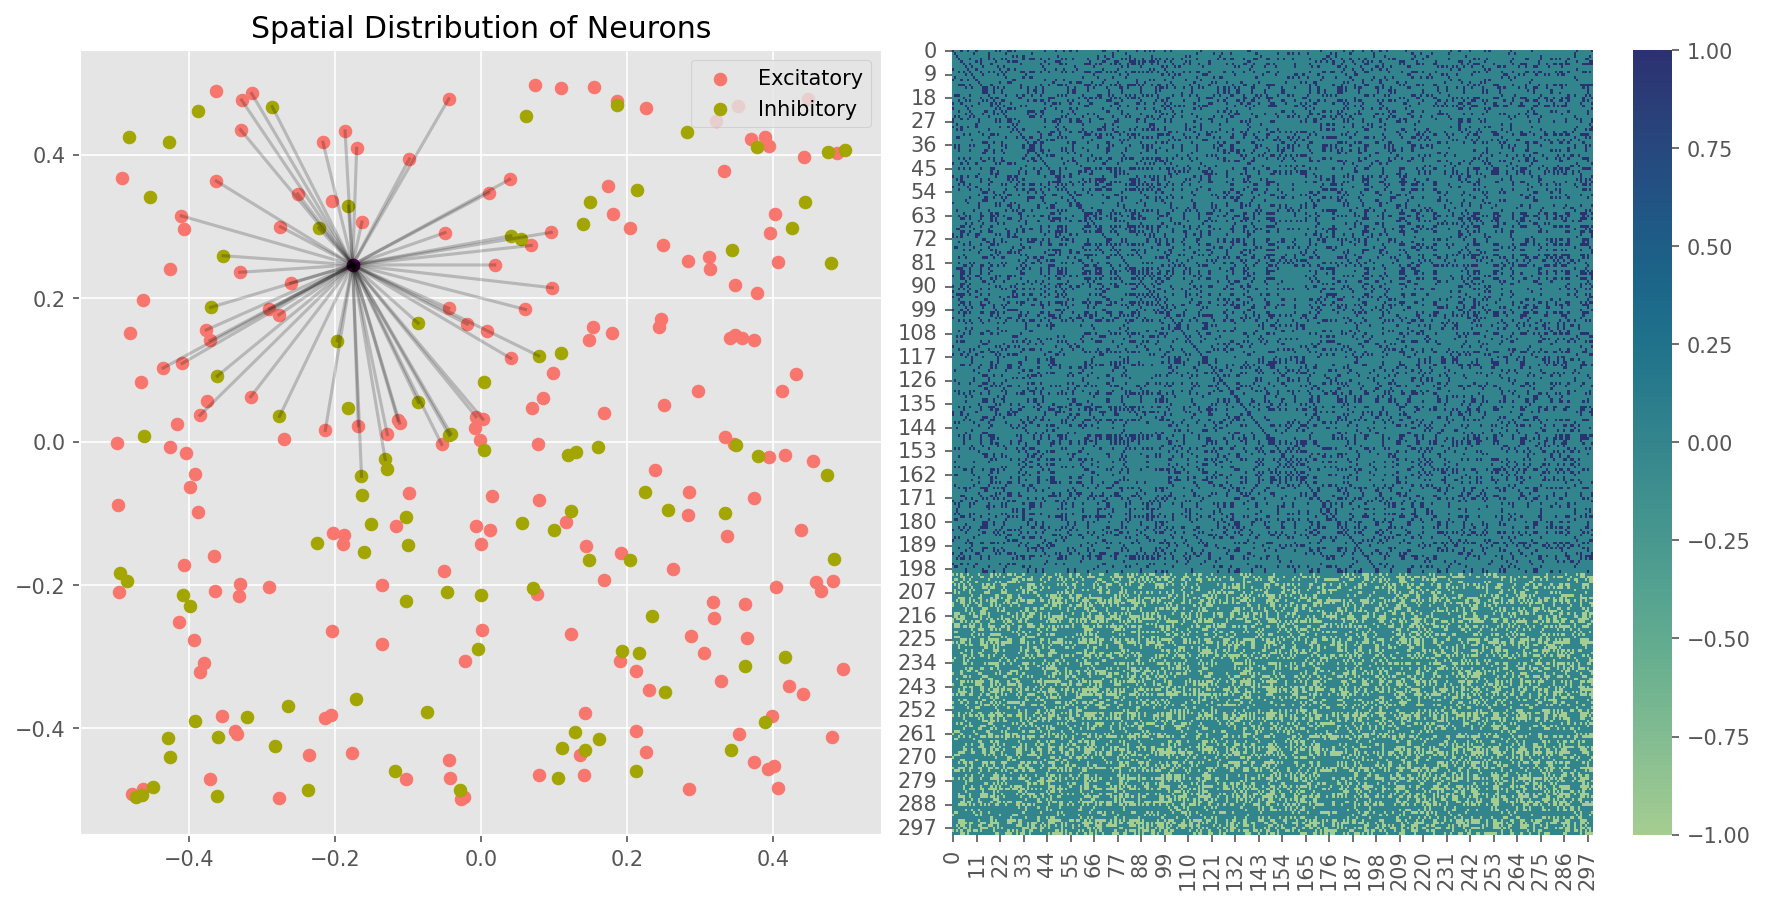

Number of excitatory connections:  11153
Number of inhibitory connections:  9462


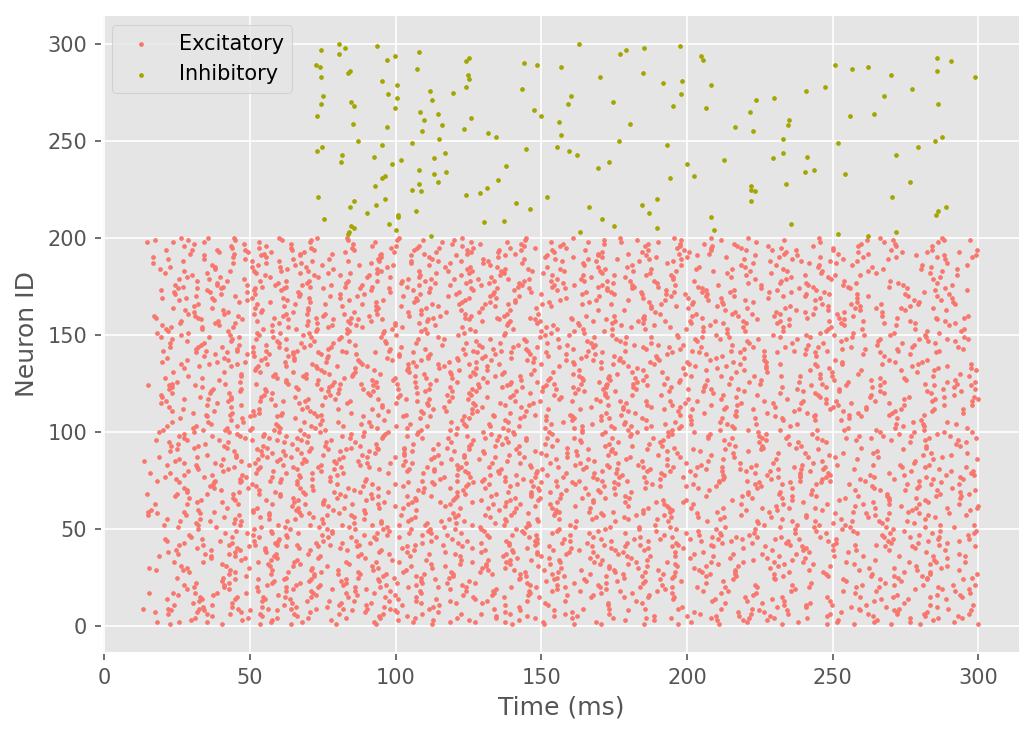

In [83]:
thalamic_firing_rate = 550

nest.ResetKernel()
layer_e, layer_i = create_populations()
connect_pop_base(layer_e, layer_i)
input = create_thalamic_input(layer_e, firing_rate=thalamic_firing_rate)
_, _, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)
nest.Simulate(300)
plot_spikes(sr_e, sr_i, sr_input)

In [84]:
print_stats(sr_e, sr_i)

Excitatory population:
  Mean firing rate: 9.08 Hz
  Variance of firing rate: 1.45
  Mean CV of ISIs: 0.44
Inhibitory population:
  Mean firing rate: 0.95 Hz
  Variance of firing rate: 0.08
  Mean CV of ISIs: 0.02


As we can see and as expected when increasing the intensity of the thalamic input we also have an increase in the activity / spikes of the network

## Pruning

To simulate synaptic pruning, we define a set of functions that selectively target and remove synapses, primarily long-range connections. We then test the network under increasing levels of stimulation to assess how its behavior deviates from that of our 'stable' baseline network

## **Pruning Strategies for Network Connectivity**

Pruning is used to **analyze the impact of connectivity reduction** on network dynamics. Two pruning strategies are applied:

- **Distance-Based Pruning**: Removes synapses where the **Euclidean distance** between the source and target neurons exceeds a given threshold. This simulates **long-range connection loss**, often observed in neurodevelopmental disorders and aging.

- **Weight-Based Pruning**: Removes synapses with **low synaptic weight**, meaning weakly connected neurons lose their links first. This represents **synaptic weakening** due to plasticity changes or network adaptation.

By comparing these strategies, we assess how different pruning mechanisms alter **network excitability and plasticity**.


In [10]:
def prune_by_distance(layer_e, layer_i, connections, distance_threshold=0.5):
    """Prunes synapses where the Euclidean distance between source and target neurons exceeds the threshold."""
    positions_exc, positions_inh = find_positions(layer_e, layer_i)
    to_remove = []
    
    for conn in connections:
        # Get source and target neuron ids from the connection
        source = list(conn.sources())[0]  # Get the first source neuron
        target = list(conn.targets())[0]  # Get the first target neuron
        
        pos_source = positions_exc.get(source) or positions_inh.get(source)
        pos_target = positions_exc.get(target) or positions_inh.get(target)
        
        if pos_source is not None and pos_target is not None:
            distance = np.linalg.norm(np.array(pos_source) - np.array(pos_target))
            if distance > distance_threshold:
                to_remove.append(conn)
    
    # Now, disconnect each connection in to_remove
    for conn in to_remove:
        nest.Disconnect(conn)
    
    return len(to_remove)


def prune_by_weight(connections, weight_threshold=0.1):
    """Prunes synapses with a weight lower than the threshold."""
    to_remove = []
    #weights = nest.GetStatus(connections, 'weight')[0]
    
    for conn in connections:
        # Get the weight of each connection using nest.GetStatus
        weight = nest.GetStatus(conn, 'weight')[0]  # Retrieve weight of the connection
        
        # If the weight is below the threshold, add the connection to the removal list
        if weight < weight_threshold:
            to_remove.append(conn)
    
    # Now, disconnect each connection in to_remove
    for conn in to_remove:
        nest.Disconnect(conn)
    
    return len(to_remove)

def apply_pruning(layer_e, layer_i, strategy="distance", param=0.4):
    """Applies the selected pruning strategy."""
    connections = nest.GetConnections()
    
    if strategy == "distance":
        removed = prune_by_distance(layer_e, layer_i, connections, distance_threshold=param)
    elif strategy == "weight":
        removed = prune_by_weight(connections, weight_threshold=param)
    else:
        raise ValueError("Invalid pruning strategy")
    
    return removed

def measure_firing_rate(layer_e, sr_e):
    """Measure the average firing rate of excitatory neurons."""
    spike_events = nest.GetStatus(sr_e, "events")[0]
    spike_times = spike_events["times"]
    num_neurons = len(layer_e)
    total_time = max(spike_times) - min(spike_times) if len(spike_times) > 1 else 1
    return len(spike_times) / (num_neurons * total_time)


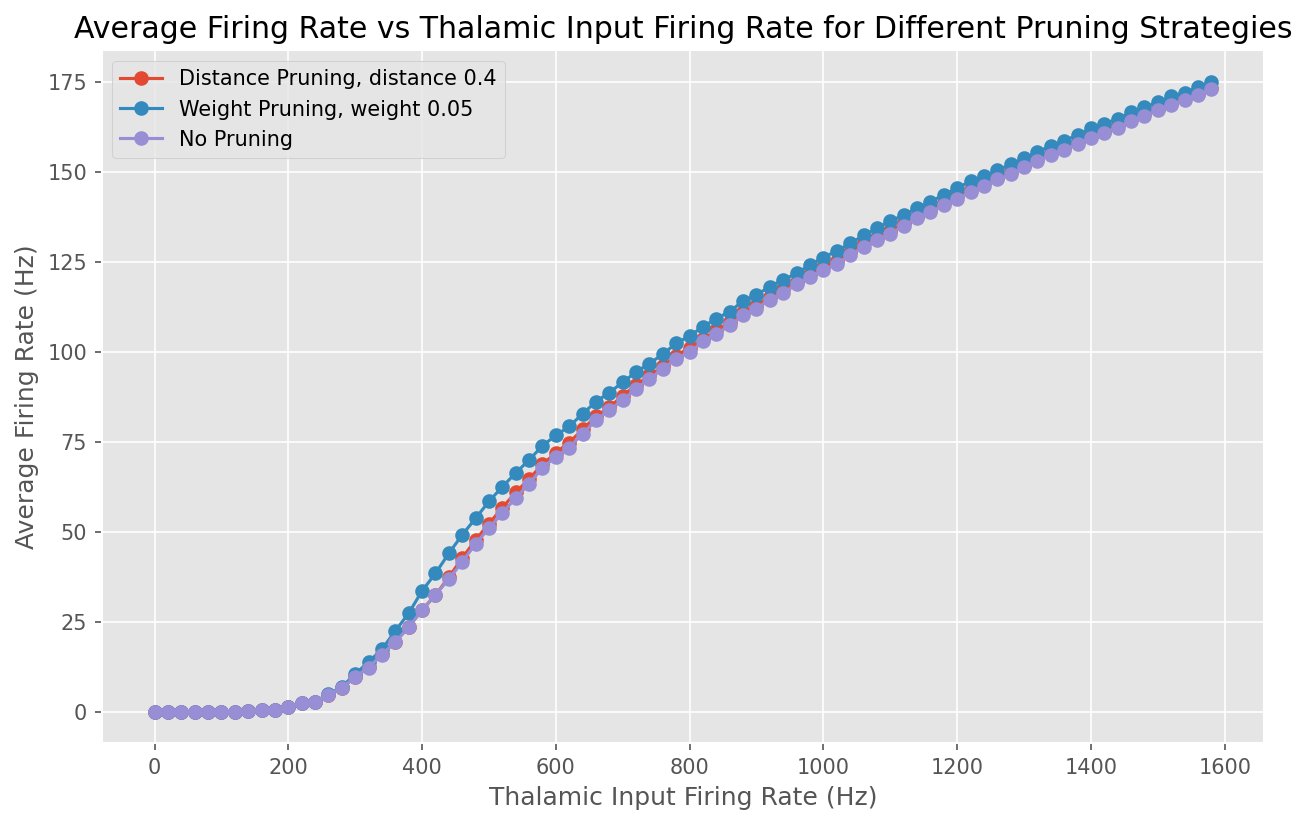

In [14]:
# Plot the results for each pruning strategy
plt.figure(figsize=(10, 6))

plt.plot(thalamic_firing_rates, firing_rates_distance, marker='o', label='Distance Pruning, distance 0.4')
plt.plot(thalamic_firing_rates, firing_rates_weight, marker='o', label='Weight Pruning, weight 0.05')
plt.plot(thalamic_firing_rates, firing_rates, marker='o', label = 'No Pruning')

plt.xlabel('Thalamic Input Firing Rate (Hz)')
plt.ylabel('Average Firing Rate (Hz)')
plt.title('Average Firing Rate vs Thalamic Input Firing Rate for Different Pruning Strategies')
plt.legend()
plt.grid(True)
plt.show()

## **Effect of Pruning on Firing Rate Response**

This plot shows the **average firing rate** as a function of **thalamic input rate** for different pruning strategies.

- **No Pruning** (purple) serves as the baseline.
- **Distance Pruning** (red) slightly increase firing rates at lower inputs but converges at high input levels.
- **Weight Pruning** (blue) has a similar effect, with minimal deviation from the baseline.

Overall, pruning has a limited impact on high-input regimes, suggesting network robustness to moderate connectivity reduction.


In [ ]:
thalamic_firing_rates = [20 * i for i in range(80)]
firing_rates_distance = []
firing_rates_weight = []
sim_time = 150.0
logged = False

# Loop over the pruning strategies
for strategy, firing_rates_list in zip([ "distance","weight"], 
                                       [firing_rates_distance,firing_rates_weight]):
    logged = False
    
    # Loop over each thalamic firing rate
    for firing_rate in thalamic_firing_rates:
        
        nest.ResetKernel()  # Reset the kernel for each firing rate

        # Recreate populations and connect them
        layer_e, layer_i = create_populations()
        connect_pop_base(layer_e, layer_i, plot_connections=False)
        
        # Apply pruning
        if strategy == "distance":
            param = 0.4  
        elif strategy == "weight":
            param = 0.05
            
        removed = apply_pruning(layer_e, layer_i, strategy, param=param)  # Adjust the 'param' as needed
        
        if not logged:
            print(f"{removed} connections removed using {strategy} pruning.")
            logged = True
        
        # Create thalamic input and recording devices
        input = create_thalamic_input(layer_e, firing_rate=firing_rate)
        _, _, sr_e, sr_i, _ = recording_devices(layer_e, layer_i, input)
        
        # Simulate the network
        nest.Simulate(sim_time)
        spike_data = nest.GetStatus(sr_e, "events")[0]

        spike_times = spike_data["times"]
        senders = spike_data["senders"]

        num_spikes = len(spike_times)
        num_neurons = len(layer_e)
        firing_rate = num_spikes / (num_neurons * (sim_time / 1000))  # Hz
        
        firing_rates_list.append(firing_rate)




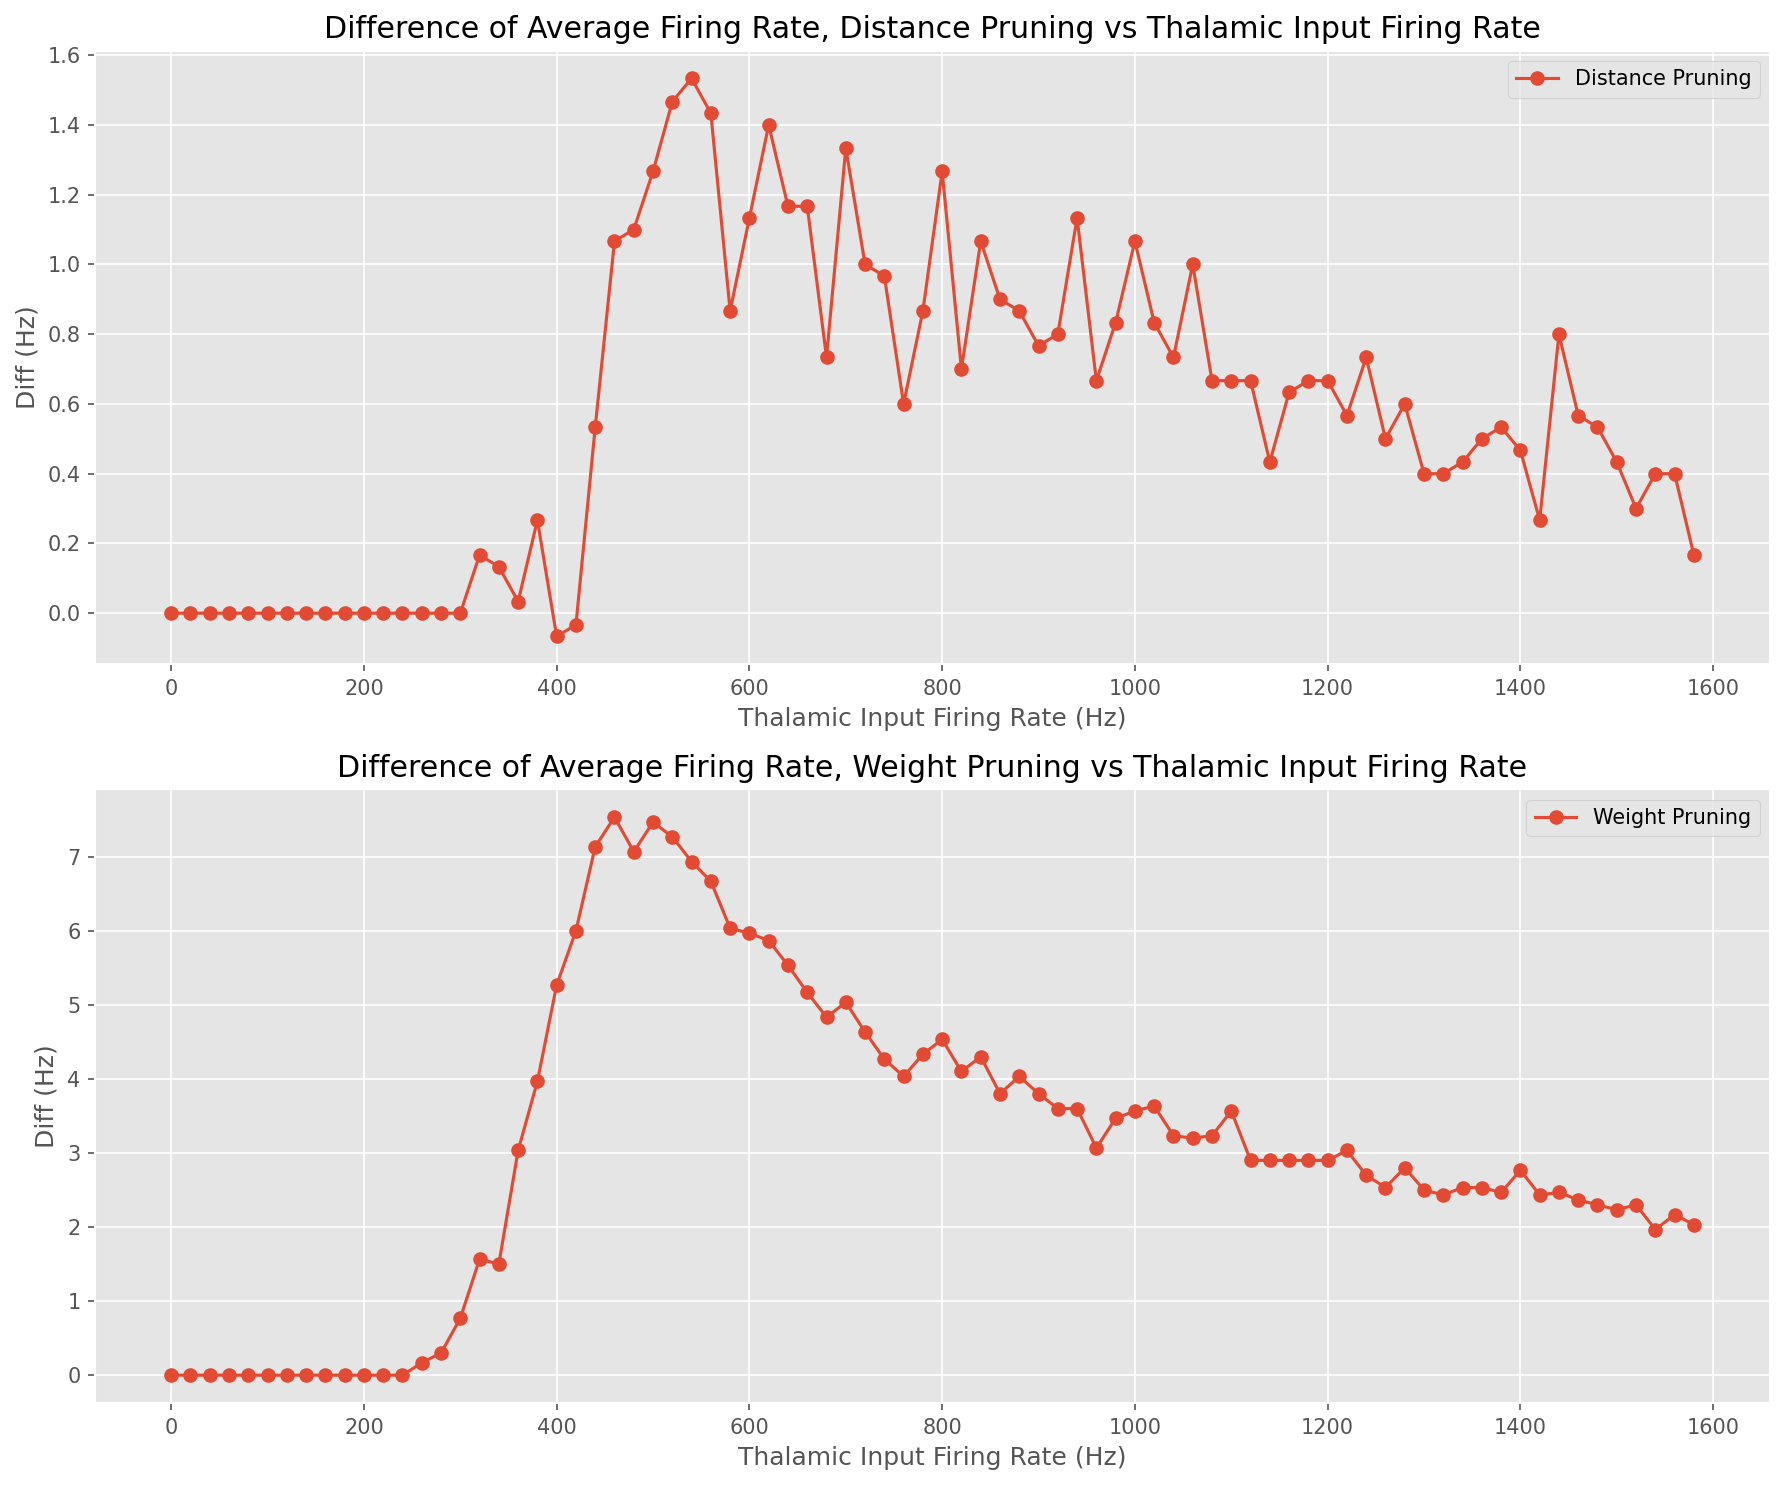

In [87]:
thalamic_firing_rates = [20 * i for i in range(80)]
firing_rates = []
sim_time = 150.0

for firing_rate in thalamic_firing_rates:
    nest.ResetKernel()
    layer_e, layer_i = create_populations()
    connect_pop_base(layer_e, layer_i, plot_connections=False)
    input = create_thalamic_input(layer_e, firing_rate=firing_rate)
    _, _, sr_e, sr_i, _ = recording_devices(layer_e, layer_i, input)
    nest.Simulate(sim_time)
    spike_data = nest.GetStatus(sr_e, "events")[0]

    spike_times = spike_data["times"]
    senders = spike_data["senders"]

    # Compute firing rate (spikes per second per neuron)
    num_spikes = len(spike_times)
    num_neurons = len(layer_e)
    firing_rate = num_spikes / (num_neurons * (sim_time / 1000))  # Hz
    firing_rates.append(firing_rate)

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Distance Pruning
axes[0].plot(thalamic_firing_rates, [i - j for i, j in zip(firing_rates_distance, firing_rates)], marker='o', label='Distance Pruning')
axes[0].set_xlabel('Thalamic Input Firing Rate (Hz)')
axes[0].set_ylabel('Diff (Hz)')
axes[0].set_title('Difference of Average Firing Rate, Distance Pruning vs Thalamic Input Firing Rate')
axes[0].grid(True)
axes[0].legend()

# Weight Pruning
axes[1].plot(thalamic_firing_rates, [i - j for i, j in zip(firing_rates_weight, firing_rates)], marker='o', label='Weight Pruning')
axes[1].set_xlabel('Thalamic Input Firing Rate (Hz)')
axes[1].set_ylabel('Diff (Hz)')
axes[1].set_title('Difference of Average Firing Rate, Weight Pruning vs Thalamic Input Firing Rate')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()



## **Pruning Effects on Network Excitability**

### **Overview**
The plots show how **pruning affects network firing rates** compared to no pruning. The y-axis represents the **increase in firing rate** due to pruning, while the x-axis is the **thalamic input firing rate (Hz).**

### **Key Findings**
- **Pruning always increases excitability**, with **weight-based pruning** having a much stronger effect than **distance-based pruning**.
- At **low input rates (0-400 Hz)**, pruning has **little effect**.
- At **mid-range input (400-800 Hz)**, excitability **peaks**, especially for weight pruning.
- At **high input rates (800-1600 Hz)**, the effect **declines but remains above baseline**.

### **Interpretation**
- **Weight pruning disrupts inhibition more**, leading to stronger excitability.
- **Distance pruning has a milder effect**, suggesting long-range connections are less critical for stability.
- **High input partially restores balance**, but pruned networks remain more excitable.

### **Implications**
- **Over-pruning can cause hyperactivity**
- **Different pruning strategies impact excitability differently**, important for **network tuning and control**.


## Monitor synapses evolution after pruning

9462 connections removed using weight pruning with param = 0.05.
11868 connections removed using distance pruning with param = 0.2.
2372 connections removed using distance pruning with param = 0.4.
215 connections removed using distance pruning with param = 0.6.


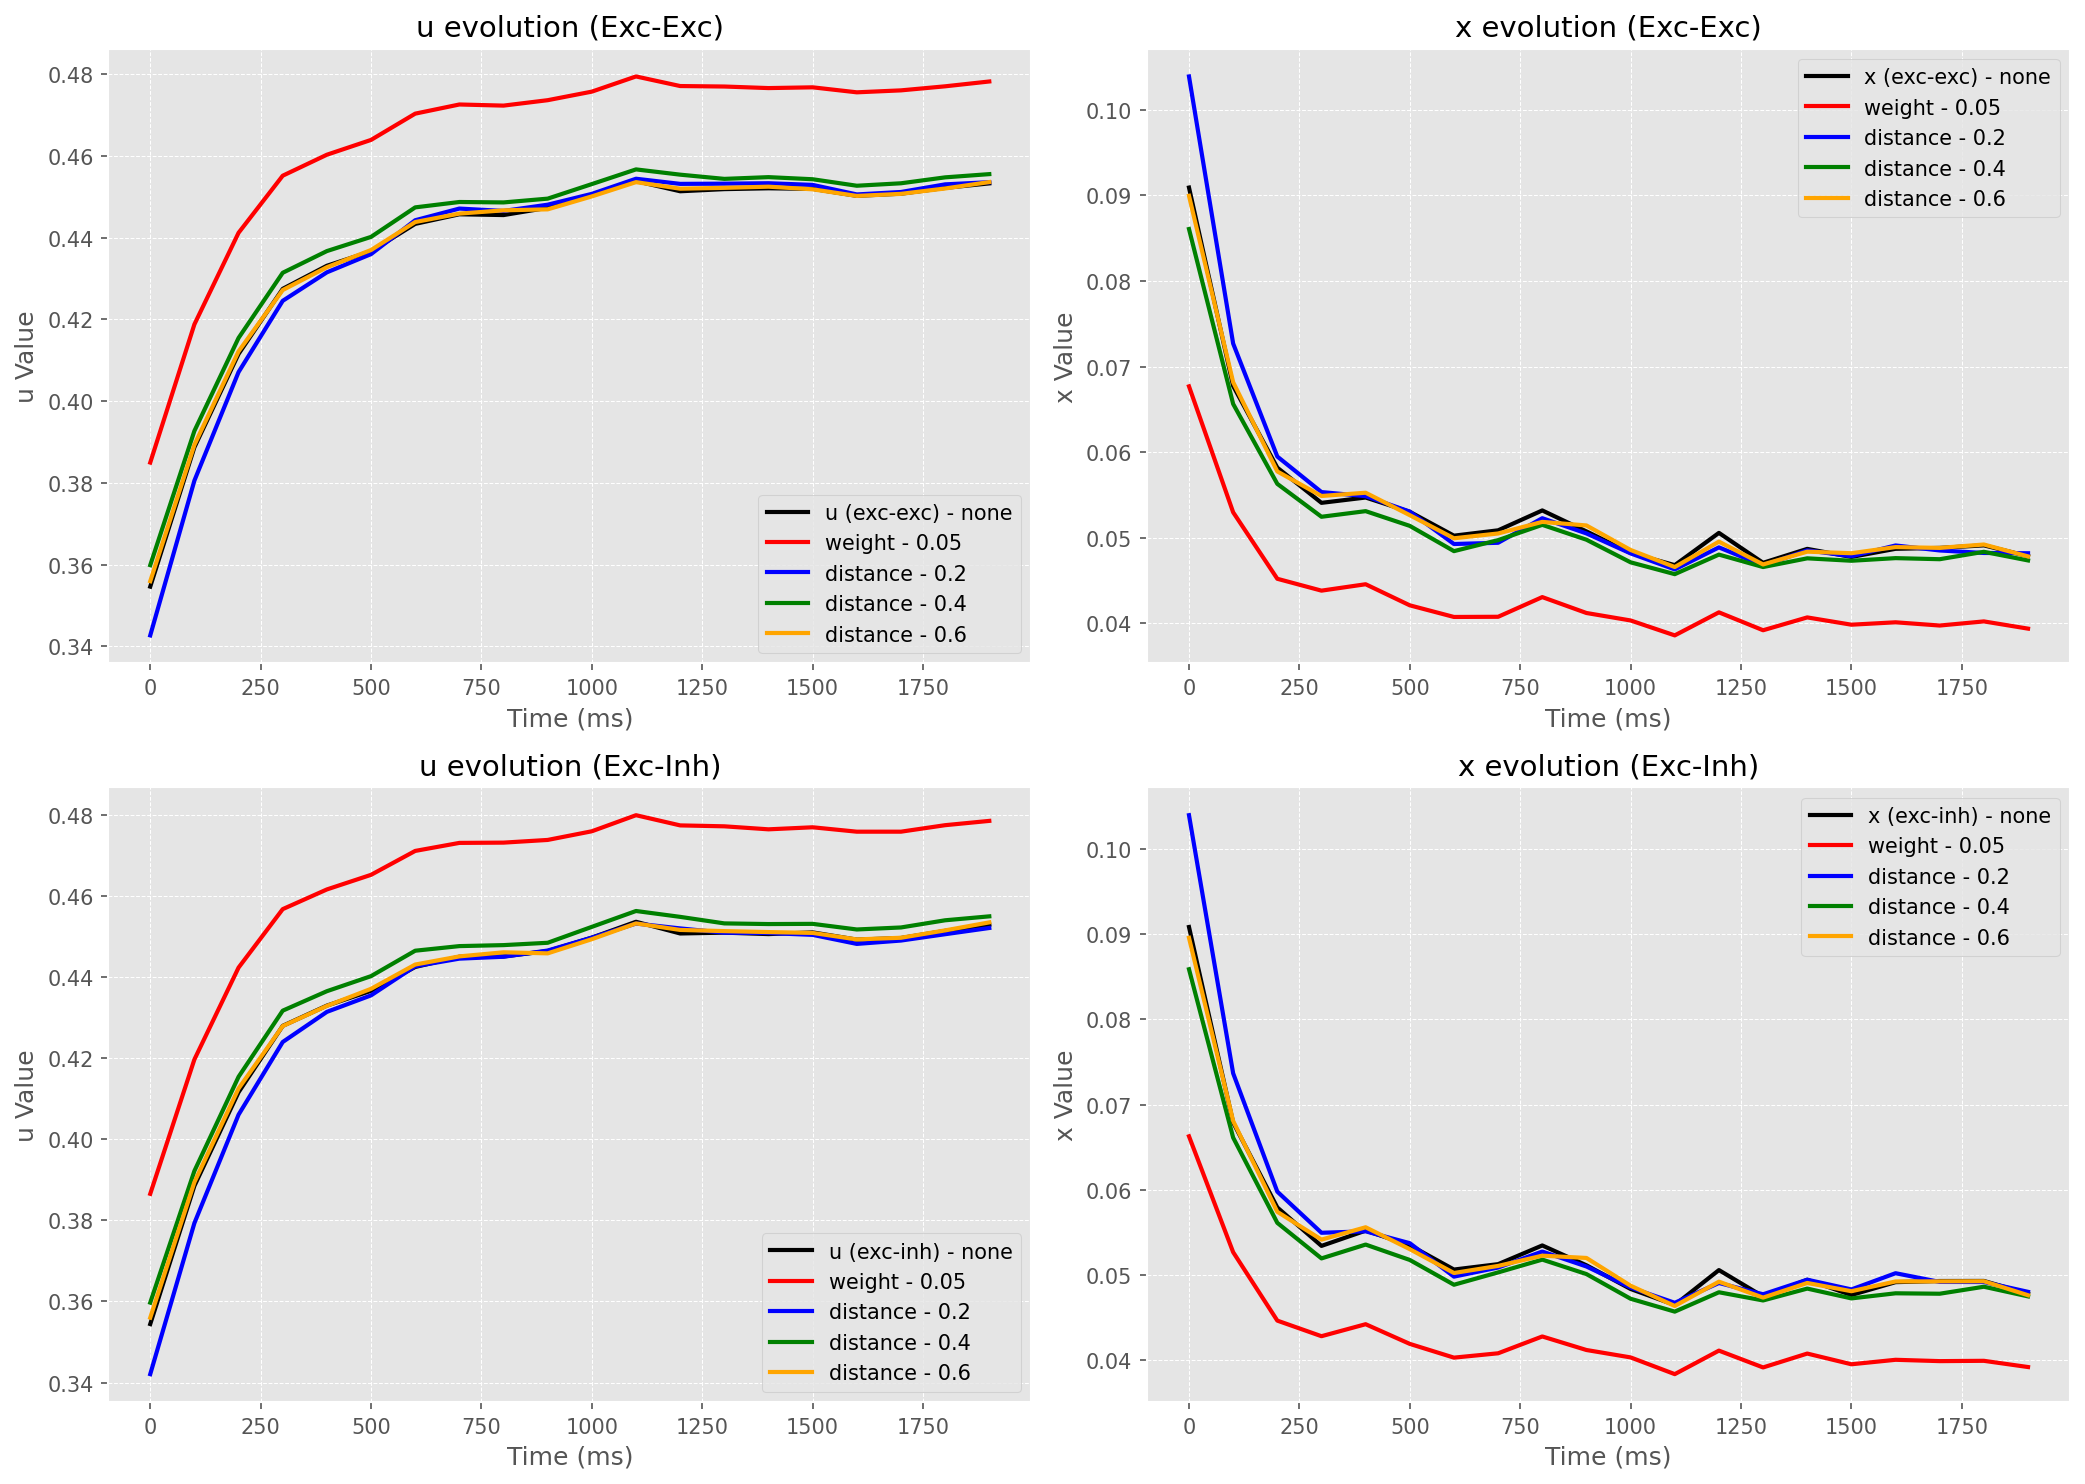

In [88]:
import numpy as np
import nest
import matplotlib.pyplot as plt

# Simulation parameters
sim_time = 300
steps = STEPS
step_duration = STEPS_DURATION
timesteps = [step_duration * step for step in range(steps)]
pruning_strategies = ["none", "weight", "distance"]
colors = {"none": "black", "weight": "red", "distance": "blue"}

# Parameter values for testing
weight_params = [0.05]
distance_params = [0.2, 0.4, 0.6]

# Dictionary to store results
results = {
    "none": {"u_exc_exc": [], "u_exc_inh": [], "x_exc_exc": [], "x_exc_inh": []},
    "weight": {param: {"u_exc_exc": [], "u_exc_inh": [], "x_exc_exc": [], "x_exc_inh": []} for param in weight_params},
    "distance": {param: {"u_exc_exc": [], "u_exc_inh": [], "x_exc_exc": [], "x_exc_inh": []} for param in distance_params},
}

for strategy in pruning_strategies:
    nest.ResetKernel()  # Reset the kernel for each condition
    
    # Recreate populations and connect them
    layer_e, layer_i = create_populations()
    connect_pop_base(layer_e, layer_i, plot_connections=False)

    if strategy == "weight":
        param_values = weight_params
    elif strategy == "distance":
        param_values = distance_params
    else:
        param_values = [None]

    for param in param_values:
        # Recreate the network from scratch for each parameter value
        nest.ResetKernel()  # Reset the kernel
        layer_e, layer_i = create_populations()
        connect_pop_base(layer_e, layer_i, plot_connections=False)

        # Apply pruning for the current parameter
        if strategy != "none":
            removed = apply_pruning(layer_e, layer_i, strategy, param)
            print(f"{removed} connections removed using {strategy} pruning with param = {param}.")
        
        # Create thalamic input and recording devices
        input = create_thalamic_input(layer_e, firing_rate=500)
        _, _, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)
        nest.Simulate(sim_time)

        # Get some connections for monitoring
        exc_exc = nest.GetConnections(source=layer_e, target=layer_e, synapse_model="synapse")
        exc_inh = nest.GetConnections(source=layer_e, target=layer_i, synapse_model="synapse")

        # Run simulation in steps and record values
        u_values_exc_exc, u_values_exc_inh, x_values_exc_exc, x_values_exc_inh = [], [], [], []
        for i in range(steps):
            # Retrieve u and x values
            u_values_exc_exc.append(nest.GetStatus(exc_exc, "u"))
            u_values_exc_inh.append(nest.GetStatus(exc_inh, "u"))
            x_values_exc_exc.append(nest.GetStatus(exc_exc, "x"))
            x_values_exc_inh.append(nest.GetStatus(exc_inh, "x"))
            
            nest.Simulate(step_duration)

        # Store results for each parameter (skip 'None' when strategy is 'none')
        if strategy == "none":
            results[strategy]["u_exc_exc"] = u_values_exc_exc
            results[strategy]["u_exc_inh"] = u_values_exc_inh
            results[strategy]["x_exc_exc"] = x_values_exc_exc
            results[strategy]["x_exc_inh"] = x_values_exc_inh
        else:
            results[strategy][param]["u_exc_exc"] = u_values_exc_exc
            results[strategy][param]["u_exc_inh"] = u_values_exc_inh
            results[strategy][param]["x_exc_exc"] = x_values_exc_exc
            results[strategy][param]["x_exc_inh"] = x_values_exc_inh

# Compute stats for all strategies and parameter values
def compute_stats(values_list):
    means = [np.mean(values) for values in values_list]
    stds = [np.std(values) for values in values_list]
    return np.array(means), np.array(stds)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plotting for u and x values across strategies and parameters
for strategy in pruning_strategies:
    color = colors[strategy]
    
    if strategy == "none":
        u_exc_exc_mean, u_exc_exc_std = compute_stats(results[strategy]["u_exc_exc"])
        u_exc_inh_mean, u_exc_inh_std = compute_stats(results[strategy]["u_exc_inh"])
        x_exc_exc_mean, x_exc_exc_std = compute_stats(results[strategy]["x_exc_exc"])
        x_exc_inh_mean, x_exc_inh_std = compute_stats(results[strategy]["x_exc_inh"])

        axes[0, 0].plot(timesteps, u_exc_exc_mean, color=color, linestyle='-', linewidth=2, label=f"u (exc-exc) - {strategy}")
        axes[1, 0].plot(timesteps, u_exc_inh_mean, color=color, linestyle='-', linewidth=2, label=f"u (exc-inh) - {strategy}")
        axes[0, 1].plot(timesteps, x_exc_exc_mean, color=color, linestyle='-', linewidth=2, label=f"x (exc-exc) - {strategy}")
        axes[1, 1].plot(timesteps, x_exc_inh_mean, color=color, linestyle='-', linewidth=2, label=f"x (exc-inh) - {strategy}")
    else:
        i = 0
        for param in results[strategy].keys():
            if i == 0:
                color = colors[strategy]
            elif i == 1:
                color = "green"
            elif i == 2:
                color = "orange"
            
            i += 1
            
            u_exc_exc_mean, u_exc_exc_std = compute_stats(results[strategy][param]["u_exc_exc"])
            u_exc_inh_mean, u_exc_inh_std = compute_stats(results[strategy][param]["u_exc_inh"])
            x_exc_exc_mean, x_exc_exc_std = compute_stats(results[strategy][param]["x_exc_exc"])
            x_exc_inh_mean, x_exc_inh_std = compute_stats(results[strategy][param]["x_exc_inh"])

            label = f"{strategy} - {param}"  # Label with strategy and param value
            axes[0, 0].plot(timesteps, u_exc_exc_mean, color=color, linestyle='-', linewidth=2, label=label)
            axes[1, 0].plot(timesteps, u_exc_inh_mean, color=color, linestyle='-', linewidth=2, label=label)
            axes[0, 1].plot(timesteps, x_exc_exc_mean, color=color, linestyle='-', linewidth=2, label=label)
            axes[1, 1].plot(timesteps, x_exc_inh_mean, color=color, linestyle='-', linewidth=2, label=label)

axes[0, 0].set_title("u evolution (Exc-Exc)", fontsize=14)
axes[0, 0].set_xlabel("Time (ms)", fontsize=12)
axes[0, 0].set_ylabel("u Value", fontsize=12)
axes[0, 0].legend(fontsize=10)

axes[1, 0].set_title("u evolution (Exc-Inh)", fontsize=14)
axes[1, 0].set_xlabel("Time (ms)", fontsize=12)
axes[1, 0].set_ylabel("u Value", fontsize=12)
axes[1, 0].legend(fontsize=10)

axes[0, 1].set_title("x evolution (Exc-Exc)", fontsize=14)
axes[0, 1].set_xlabel("Time (ms)", fontsize=12)
axes[0, 1].set_ylabel("x Value", fontsize=12)
axes[0, 1].legend(fontsize=10)

axes[1, 1].set_title("x evolution (Exc-Inh)", fontsize=14)
axes[1, 1].set_xlabel("Time (ms)", fontsize=12)
axes[1, 1].set_ylabel("x Value", fontsize=12)
axes[1, 1].legend(fontsize=10)

for ax in axes.flatten():
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
plt.tight_layout()
plt.show()


## **Effect of Pruning on Short-Term Plasticity (u & x Evolution)**

- **u (facilitation) increases** more with **weight pruning**, indicating stronger synaptic responses.
- **Distance pruning has a smaller effect**, staying close to the baseline.
- **x (depression) decreases faster** with **weight pruning**, meaning synapses deplete more quickly.
- **Distance pruning preserves synaptic balance**, keeping x values near the baseline.
- **Weight pruning disrupts synaptic dynamics more**, leading to stronger but less sustainable responses.


# Simulation giving a constant input

In this section we provide two DC constant inputs to the networks at two different time steps (whose intensity can be changed) and simulate and plot the activity for the two

In [89]:
def simulate_network(dc_amplitude_1, dc_amplitude_2, pruning=False, strat="weight", prm=0.05):
    """
    Run the simulation using the provided DC amplitude.
    Returns:
      - avg_rate_e: average firing rate (Hz) for excitatory population
      - avg_rate_i: average firing rate (Hz) for inhibitory population
      - times_e: spike times of excitatory neurons (for population activity)
      - times_i: spike times of inhibitory neurons (for population activity)
    """
    nest.ResetKernel()

    layer_e, layer_i = create_populations()
    connect_pop_base(layer_e, layer_i, plot_connections=False)

    if pruning:
        print("applying pruning")
        removed = apply_pruning(layer_e, layer_i, strategy=strat, param=prm)
        print(f"{removed} connections removed using {strat} pruning with param = {prm}.")
    
    dc_input = create_dc_input(layer_e, start=DC_INPUT_START_1, stop=DC_INPUT_STOP_1)
    nest.SetStatus(dc_input, {"amplitude": dc_amplitude_1})
    
    dc_input2 = create_dc_input(layer_e, start=DC_INPUT_START_2, stop=DC_INPUT_STOP_2)
    nest.SetStatus(dc_input2, {"amplitude": dc_amplitude_2})
    thalamic = create_thalamic_input(layer_e)
    
    mr_e, mr_i, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, thalamic)
    
    nest.Simulate(SIM_TIME)
    
    n_spikes_e = nest.GetStatus(sr_e, "n_events")[0]
    n_spikes_i = nest.GetStatus(sr_i, "n_events")[0]
    
    avg_rate_e = n_spikes_e / (len(layer_e) * (SIM_TIME / 1000.0))
    avg_rate_i = n_spikes_i / (len(layer_i) * (SIM_TIME / 1000.0))

    events_e = nest.GetStatus(sr_e, "events")[0]
    times_e = events_e["times"] if "times" in events_e else np.array([])
    
    events_i = nest.GetStatus(sr_i, "events")[0]
    times_i = events_i["times"] if "times" in events_i else np.array([])
    
    return avg_rate_e, avg_rate_i, times_e, times_i, sr_e, sr_i

def plot_population_activity(times_e, times_i, bin_size=50):
    """
    Plot binned spike counts (population activity) for excitatory and inhibitory populations.
    """
    bins = np.arange(0, SIM_TIME + bin_size, bin_size)
    
    hist_e, _ = np.histogram(times_e, bins=bins)
    hist_i, _ = np.histogram(times_i, bins=bins)
    bin_centers = bins[:-1] + bin_size / 2.0

    pop_fig = go.Figure()
    pop_fig.add_trace(go.Scatter(x=bin_centers, y=hist_e, mode="lines+markers", name="Excitatory"))
    pop_fig.add_trace(go.Scatter(x=bin_centers, y=hist_i, mode="lines+markers", name="Inhibitory"))
    pop_fig.update_layout(
        title="Population Activity Over Time",
        xaxis_title="Time (ms)",
        yaxis_title=f"Spike Count per {bin_size} ms bin"
    )
    return pop_fig

def plot_dc_input(dc_amplitude_1, dc_amplitude_2, sim_time=SIM_TIME, dt=1):
    """
    Plot the DC input signals as step functions over the simulation time.
    """
    time = np.arange(0, sim_time + dt, dt)
    dc1 = np.zeros_like(time, dtype=float)
    dc2 = np.zeros_like(time, dtype=float)
    
    dc1[(time >= DC_INPUT_START_1) & (time <= DC_INPUT_STOP_1)] = dc_amplitude_1
    dc2[(time >= DC_INPUT_START_2) & (time <= DC_INPUT_STOP_2)] = dc_amplitude_2
    
    dc_fig = go.Figure()
    dc_fig.add_trace(go.Scatter(x=time, y=dc1, mode='lines', name='DC Input 1', line=dict(color='teal', width=2)))
    dc_fig.add_trace(go.Scatter(x=time, y=dc2, mode='lines', name='DC Input 2', line=dict(color='magenta', width=2)))
    dc_fig.update_layout(
        title="DC Inputs Over Time",
        xaxis_title="Time (ms)",
        yaxis_title="Amplitude (pA)"
    )
    return dc_fig

def plot_spikes_plotly(sr_e, sr_i):
    """
    Plot a spike raster (scatter plot of spikes) using Plotly.
    Returns a Plotly figure.
    """
    events_e = nest.GetStatus(sr_e, "events")[0]
    events_i = nest.GetStatus(sr_i, "events")[0]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=events_e["times"], y=events_e["senders"],
        mode="markers",
        marker=dict(color="#f8766d", size=3),
        name="Excitatory"
    ))
    fig.add_trace(go.Scatter(
        x=events_i["times"], y=events_i["senders"],
        mode="markers",
        marker=dict(color="#a3a500", size=3),
        name="Inhibitory"
    ))
    fig.update_layout(
        title="Spike Raster Plot",
        xaxis_title="Time (ms)",
        yaxis_title="Neuron ID"
    )
    return fig

def update_plots_unpruned(dc_amplitude_1, dc_amplitude_2):
    """
    Run simulation for the unpruned network and display:
      - A bar chart of average firing rates.
      - A spike raster plot.
    """
    avg_rate_e, avg_rate_i, times_e, times_i, sr_e, sr_i = simulate_network(dc_amplitude_1, dc_amplitude_2, pruning=False)
    
    # Bar chart for average firing rates.
    bar_fig = go.Figure(data=[
        go.Bar(name='Excitatory', x=['Excitatory'], y=[avg_rate_e], marker_color='#f8766d'),
        go.Bar(name='Inhibitory', x=['Inhibitory'], y=[avg_rate_i], marker_color='#b8b942')
    ])
    bar_fig.update_layout(
        title=f"Unpruned Network Firing Rates (DC1: {dc_amplitude_1} pA, DC2: {dc_amplitude_2} pA)",
        xaxis_title="Population",
        yaxis_title="Firing Rate (Hz)",
        barmode='group'
    )

    pop_fig = plot_population_activity(times_e, times_i, bin_size=50)
    
    dc_fig = plot_dc_input(dc_amplitude_1, dc_amplitude_2, sim_time=SIM_TIME, dt=1)
    
    raster_fig = plot_spikes_plotly(sr_e, sr_i)
    dc_fig.show()
    pop_fig.show()
    raster_fig.show()
    bar_fig.show()

def update_plots_pruned(dc_amplitude_1, dc_amplitude_2, strat, prm):
    """
    Run simulation for the pruned network and display:
      - A bar chart of average firing rates.
      - A spike raster plot.
    """
    avg_rate_e, avg_rate_i, times_e, times_i, sr_e, sr_i = simulate_network(dc_amplitude_1, dc_amplitude_2, pruning=True, strat=strat, prm=prm)
    
    # Bar chart for average firing rates.
    bar_fig = go.Figure(data=[
        go.Bar(name='Excitatory', x=['Excitatory'], y=[avg_rate_e], marker_color='#f8766d'),
        go.Bar(name='Inhibitory', x=['Inhibitory'], y=[avg_rate_i], marker_color='#b8b942')
    ])
    bar_fig.update_layout(
        title=f"Pruned Network Firing Rates (DC1: {dc_amplitude_1} pA, DC2: {dc_amplitude_2} pA)",
        xaxis_title="Population",
        yaxis_title="Firing Rate (Hz)",
        barmode='group'
    )
    
    pop_fig = plot_population_activity(times_e, times_i, bin_size=50)
    
    dc_fig = plot_dc_input(dc_amplitude_1, dc_amplitude_2, sim_time=SIM_TIME, dt=1)
    
    raster_fig = plot_spikes_plotly(sr_e, sr_i)
    dc_fig.show()
    pop_fig.show()
    raster_fig.show()
    bar_fig.show()




### Unpruned Network
Parameters that can be changed:
- DC input intensities

In [90]:
dc_slider1_unpruned = widgets.FloatSlider(
    value=DC_INPUT_AMPLITUDE,
    min=0,
    max=500,
    step=10,
    description='DC Input 1 (pA):',
    continuous_update=False
)
dc_slider2_unpruned = widgets.FloatSlider(
    value=DC_INPUT_AMPLITUDE,
    min=0,
    max=500,
    step=10,
    description='DC Input 2 (pA):',
    continuous_update=False
)
print("Unpruned Network:")
widgets.interact(update_plots_unpruned, dc_amplitude_1=dc_slider1_unpruned, dc_amplitude_2=dc_slider2_unpruned)

Unpruned Network:


interactive(children=(FloatSlider(value=300.0, continuous_update=False, description='DC Input 1 (pA):', max=50…

<function __main__.update_plots_unpruned(dc_amplitude_1, dc_amplitude_2)>

### Pruned Network
Parameters to be changed:
- DC input amplitudes
- Pruning startegy
- Threshold for the pruning strategy

In [91]:
dc_slider1_pruned = widgets.FloatSlider(
    value=DC_INPUT_AMPLITUDE,
    min=0,
    max=500,
    step=10,
    description='DC Input 1 (pA):',
    continuous_update=False
)
dc_slider2_pruned = widgets.FloatSlider(
    value=DC_INPUT_AMPLITUDE,
    min=0,
    max=500,
    step=10,
    description='DC Input 2 (pA):',
    continuous_update=False
)
pruning_strategy = widgets.Dropdown(
    options=['weight', 'distance'],
    value='weight',
    description='Pruning Strategy:'
)
pruning_param = widgets.FloatSlider(
    value=0.05,
    min=0,
    max=1,
    step=0.01,
    description='Pruning Param:',
    continuous_update=False
)
print("Pruned Network:")
widgets.interact(update_plots_pruned, 
                 dc_amplitude_1=dc_slider1_pruned, 
                 dc_amplitude_2=dc_slider2_pruned, 
                 strat=pruning_strategy,
                 prm=pruning_param)

Pruned Network:


interactive(children=(FloatSlider(value=300.0, continuous_update=False, description='DC Input 1 (pA):', max=50…

<function __main__.update_plots_pruned(dc_amplitude_1, dc_amplitude_2, strat, prm)>